In [1]:
"""Analysis notebook for the Marconi HPC tests.
"""

import sys
import csv
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.cm import get_cmap

# Check Python version
py_ver = sys.version.split("\n")[0]
print(f"Hello, we are using Python {py_ver}")
del py_ver

Hello, we are using Python 3.7.3 (default, Mar 27 2019, 09:23:15) 


In [2]:
# Adjust figure size for Matplotlib
matplotlib.rcParams["figure.figsize"] = [16, 10]
matplotlib.rcParams["figure.dpi"] = 200

In [3]:
def to_bool(s):
    """Convert a string to bool.
    """
    return s.lower() in [ "true", "yes", "on", "1" ]

def get_tuple(raw, fields, cond={}, cond_eval="True"):
    """Given a list of dictionaries in `raw`, returns a tuple of lists, each one of them
       representing the fields specified by `fields`.
       Results are filtered by the conditions expressed in `cond` and `condEval`.
       Example:
           a,b = getTuple(plot_raw, ("nJobs", "wallTime"), {"nEvt": 200})
       Gets two lists: a with the list of nJobs, b with the list of wallTime.
       a,b can be passed as arguments to matplotlib plot functions.
    """
    x = ( tuple(map(x.get, fields)) for x in raw if all(x[k] == v for k,v in cond.items()) and \
                                                    (eval(cond_eval)) )
    return map(list, zip(*x))

def load_csv(csv_fn, cond_eval="True", quiet=False):
    """Loads from `csv_fn`, outputs a list of dictionaries.
       Performs type conversions in the process.
       Discards fields not matching `cond_eval`.
    """
    conv_default = int
    conv_map = { "success": to_bool, "shMem": to_bool, "cpuEff": float }
    sort_func = lambda x: 100000 * x.get("nEvt", 0) + \
                          1000 * x.get("nInst", 0) + \
                          x.get("nProc", 0) + x.get("nJobs", 0)
    raw = []
    with open(csv_fn) as ch:
        cr = csv.DictReader(ch)
        pk = True
        for rec in cr:
            if pk:
                print(f"Keys from {csv_fn}: {', '.join(rec.keys())}")
                pk = False
            # Convert field types
            for f in rec:
                typ = conv_map.get(f, conv_default)
                rec[f] = typ(rec[f])
            nEvt = rec["nEvt"]
            if eval(cond_eval):
                raw.append(dict(rec))
            elif not quiet:
                print(f"WARNING: discarded: {dict(rec)}")

    raw.sort(key=sort_func)
    return raw

Keys from scalability_proc.csv: jobId, nEvt, nJobs, success, shMem, cpuTime, wallTime, userCpu, aveRss, maxRss


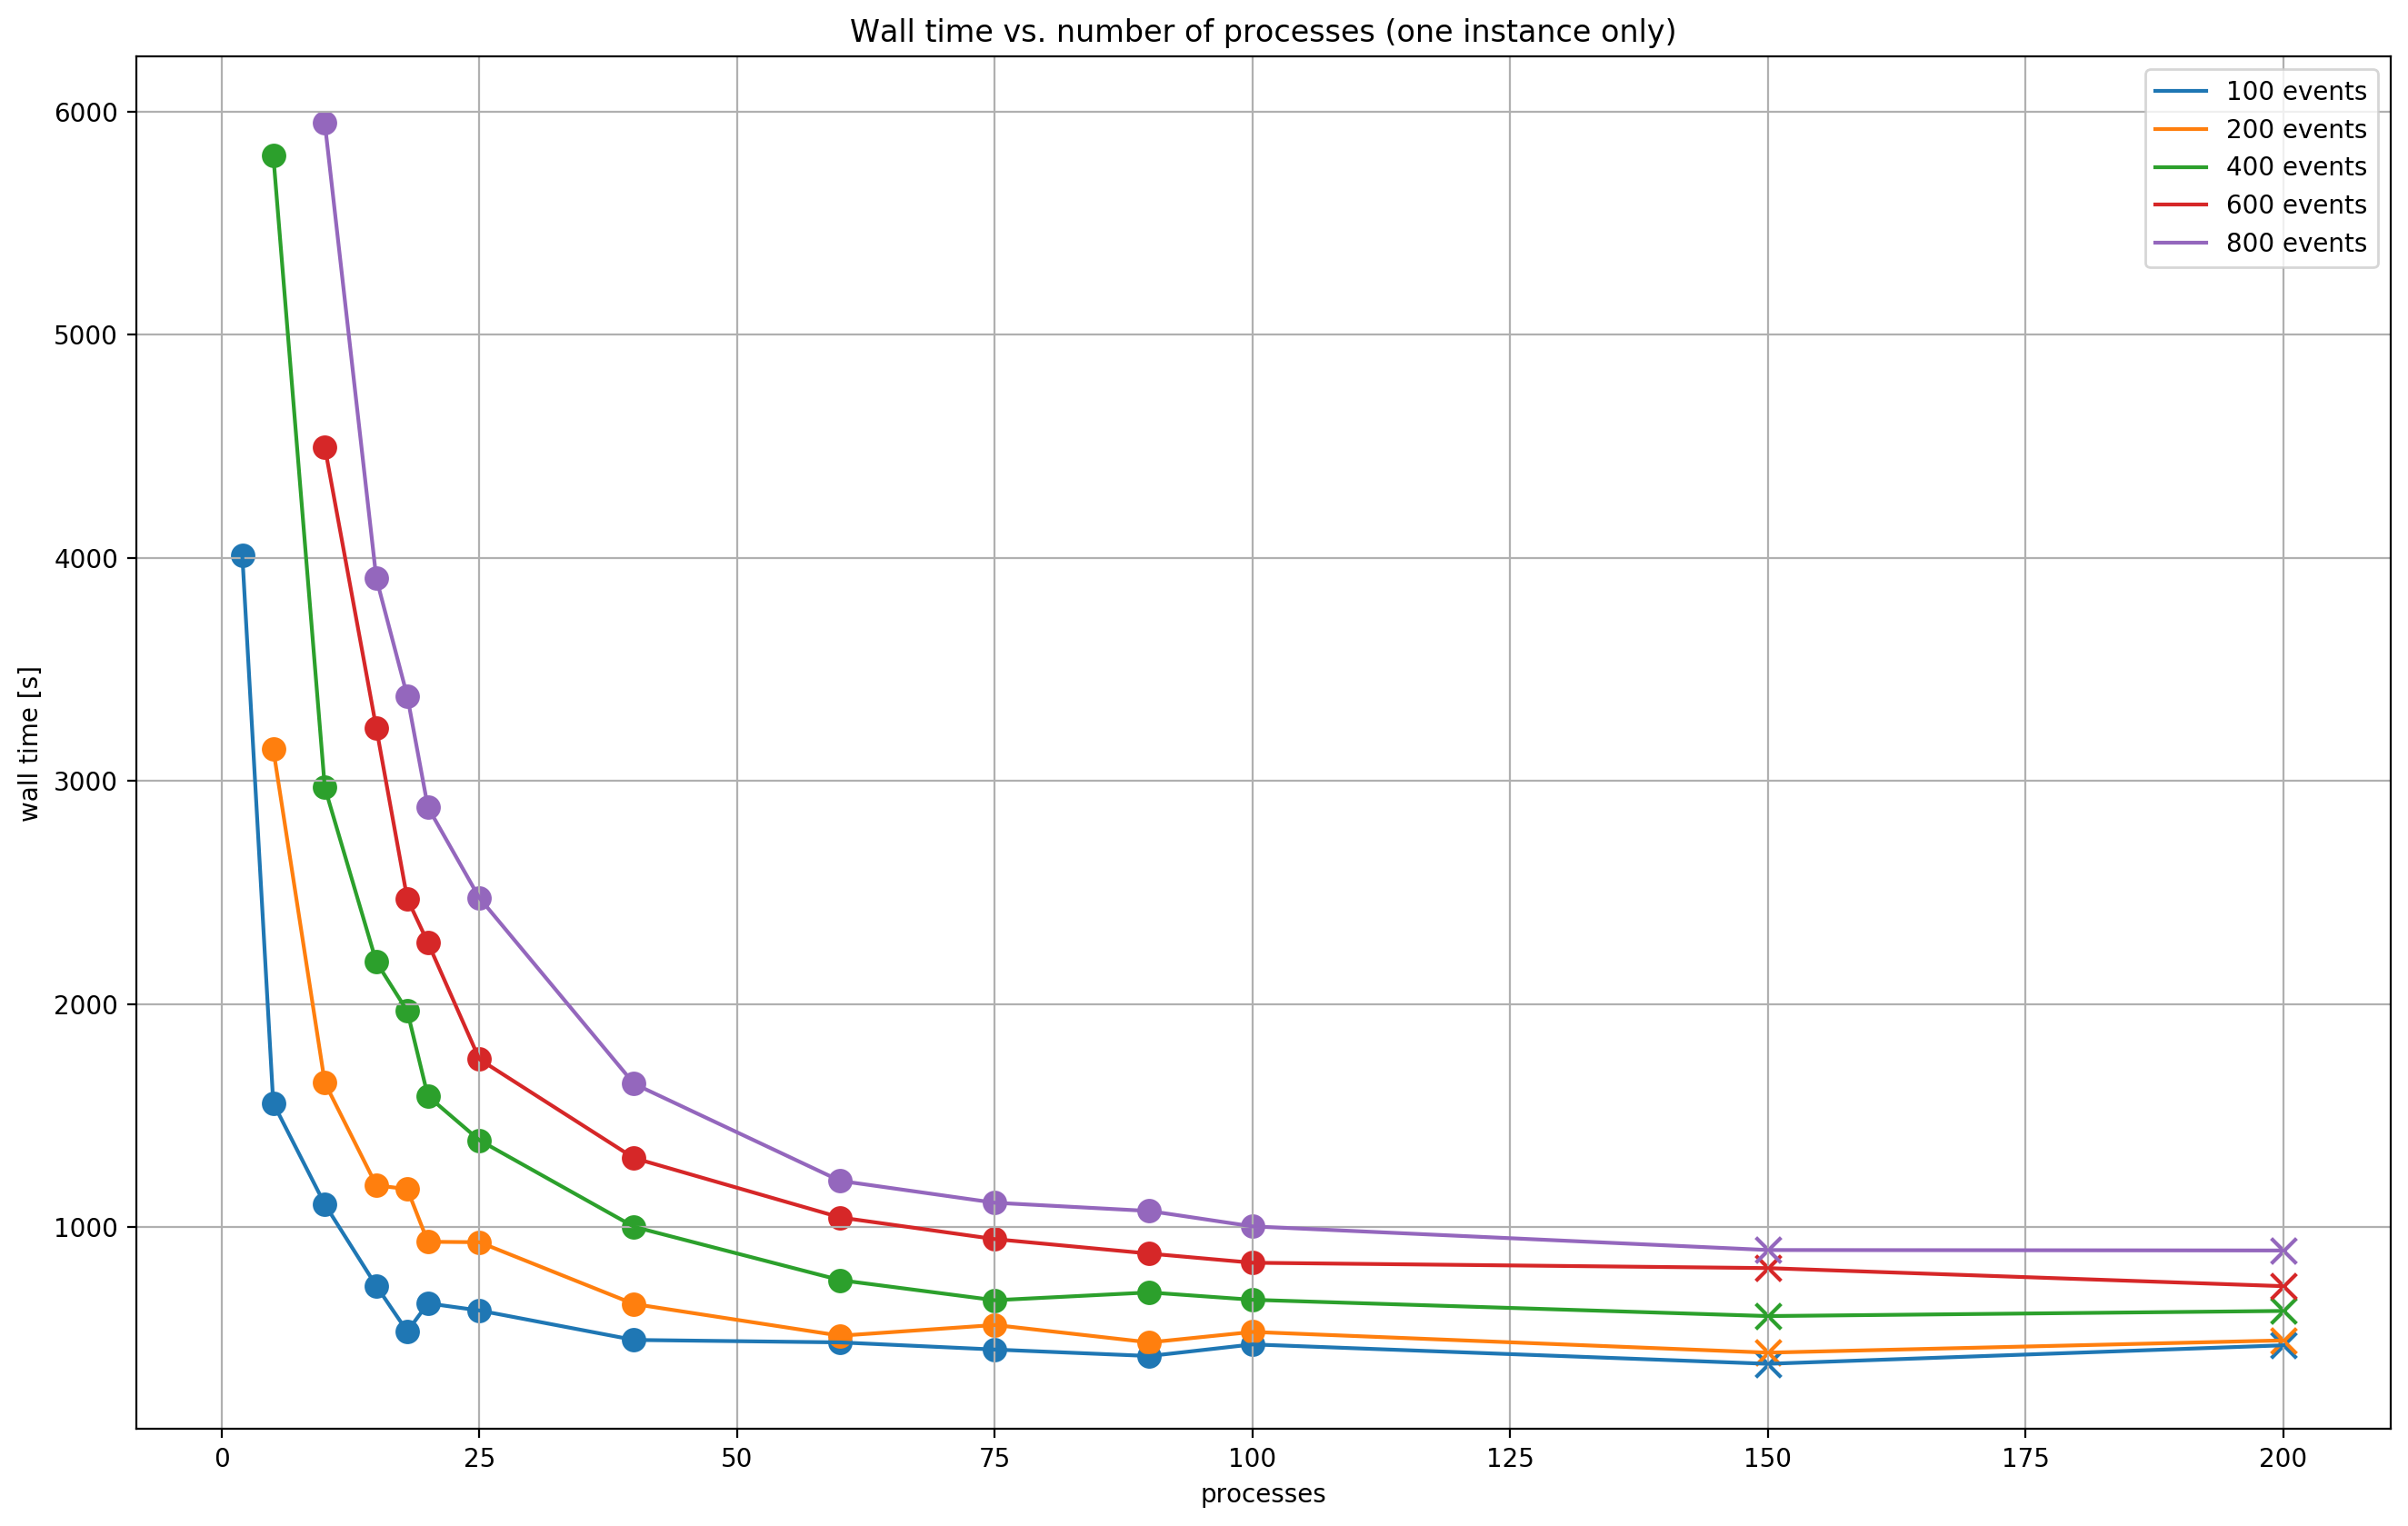

In [4]:
# Plot wall time vs. number of processes
scale_raw = load_csv("scalability_proc.csv", "rec['success']")
scale_fig,scale_ax = plt.subplots()
cycol = cycler("color", get_cmap("tab10").colors).__iter__()
for n_evt in sorted({x["nEvt"] for x in scale_raw}):
    x,y = get_tuple(scale_raw, ("nJobs", "wallTime"), {"nEvt": n_evt})
    prop = cycol.__next__()
    # Lines
    scale_ax.plot(x, y, "-", label=f"{n_evt} events", **prop)
    # Plot different dots if shMem or zmq
    x1,y1 = get_tuple(scale_raw, ("nJobs", "wallTime"), {"nEvt": n_evt, "shMem": True})   # shmem
    scale_ax.scatter(x1, y1, s=75, marker="o", **prop)
    x2,y2 = get_tuple(scale_raw, ("nJobs", "wallTime"), {"nEvt": n_evt, "shMem": False})   # zmq
    scale_ax.scatter(x2, y2, s=100, marker="x", **prop)
scale_ax.grid(True)
scale_ax.legend()
scale_ax.set_title("Wall time vs. number of processes (one instance only)")
scale_ax.set_xlabel("processes")
scale_ax.set_ylabel("wall time [s]");
del x, y, x1, y1, x2, y2, prop, cycol, n_evt

Keys from slurm_stats.csv: jobId, nEvt, nProc, nInst, nInstOk, nShMem, slurmUserCpu, slurmWallTime, slurmAveRss, slurmMaxRss


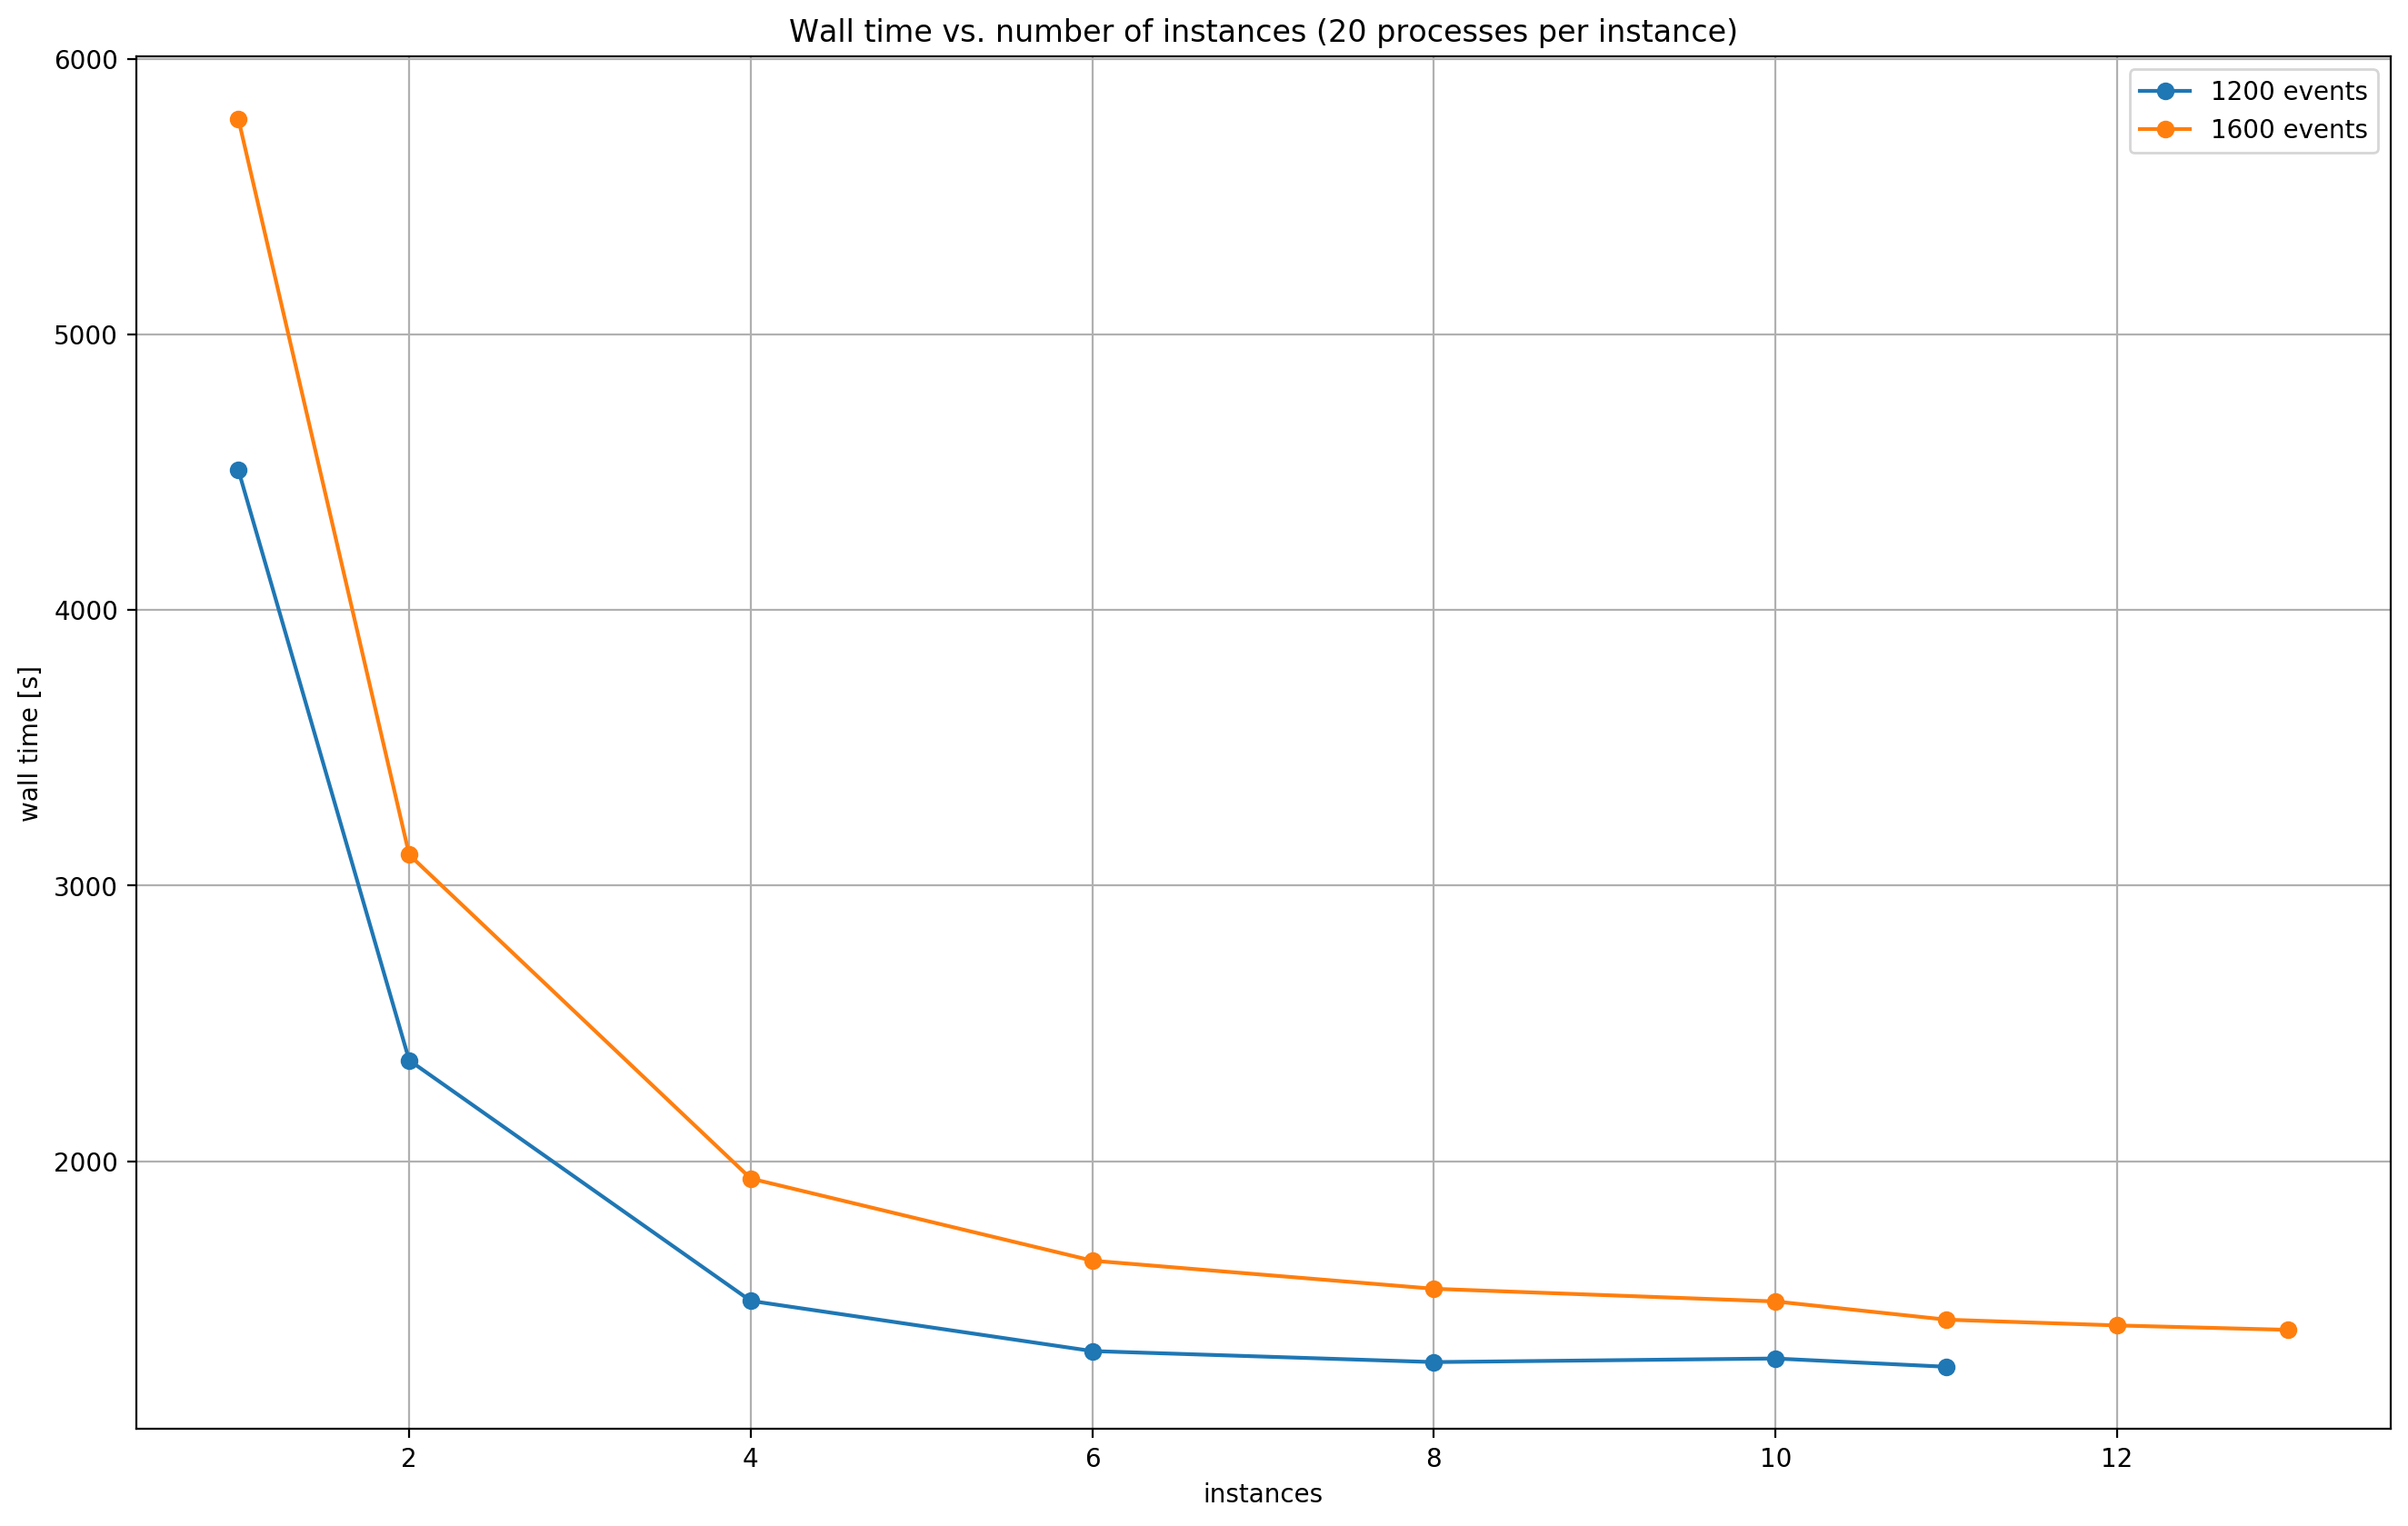

In [5]:
# Plot wall time vs. number of instances
mult_raw = load_csv("slurm_stats.csv", "rec['nInstOk'] == rec['nInst']")
mult_fig,mult_ax = plt.subplots()
cycol = cycler("color", get_cmap("tab10").colors).__iter__()
for n_evt in sorted({x["nEvt"] for x in mult_raw}):
    x,y = get_tuple(mult_raw, ("nInst", "slurmWallTime"), {"nEvt": n_evt})
    prop = cycol.__next__()
    # Lines
    mult_ax.plot(x, y, "o-", label=f"{n_evt} events", **prop)
mult_ax.grid(True)
mult_ax.legend()
mult_ax.set_title(f"Wall time vs. number of instances ({mult_raw[0]['nProc']} processes per instance)")
mult_ax.set_xlabel("instances")
mult_ax.set_ylabel("wall time [s]");
del x, y, prop, cycol, n_evt

Keys from psmon_slurm.csv: jobId, nEvt, nProc, nInst, nInstOk, nShMem, slurmUserCpu, slurmWallTime, slurmAveRss, slurmMaxRss
Keys from psmon.csv: jobId, nEvt, nProc, nInst, elapsed, cpuEff, vsz, rsz


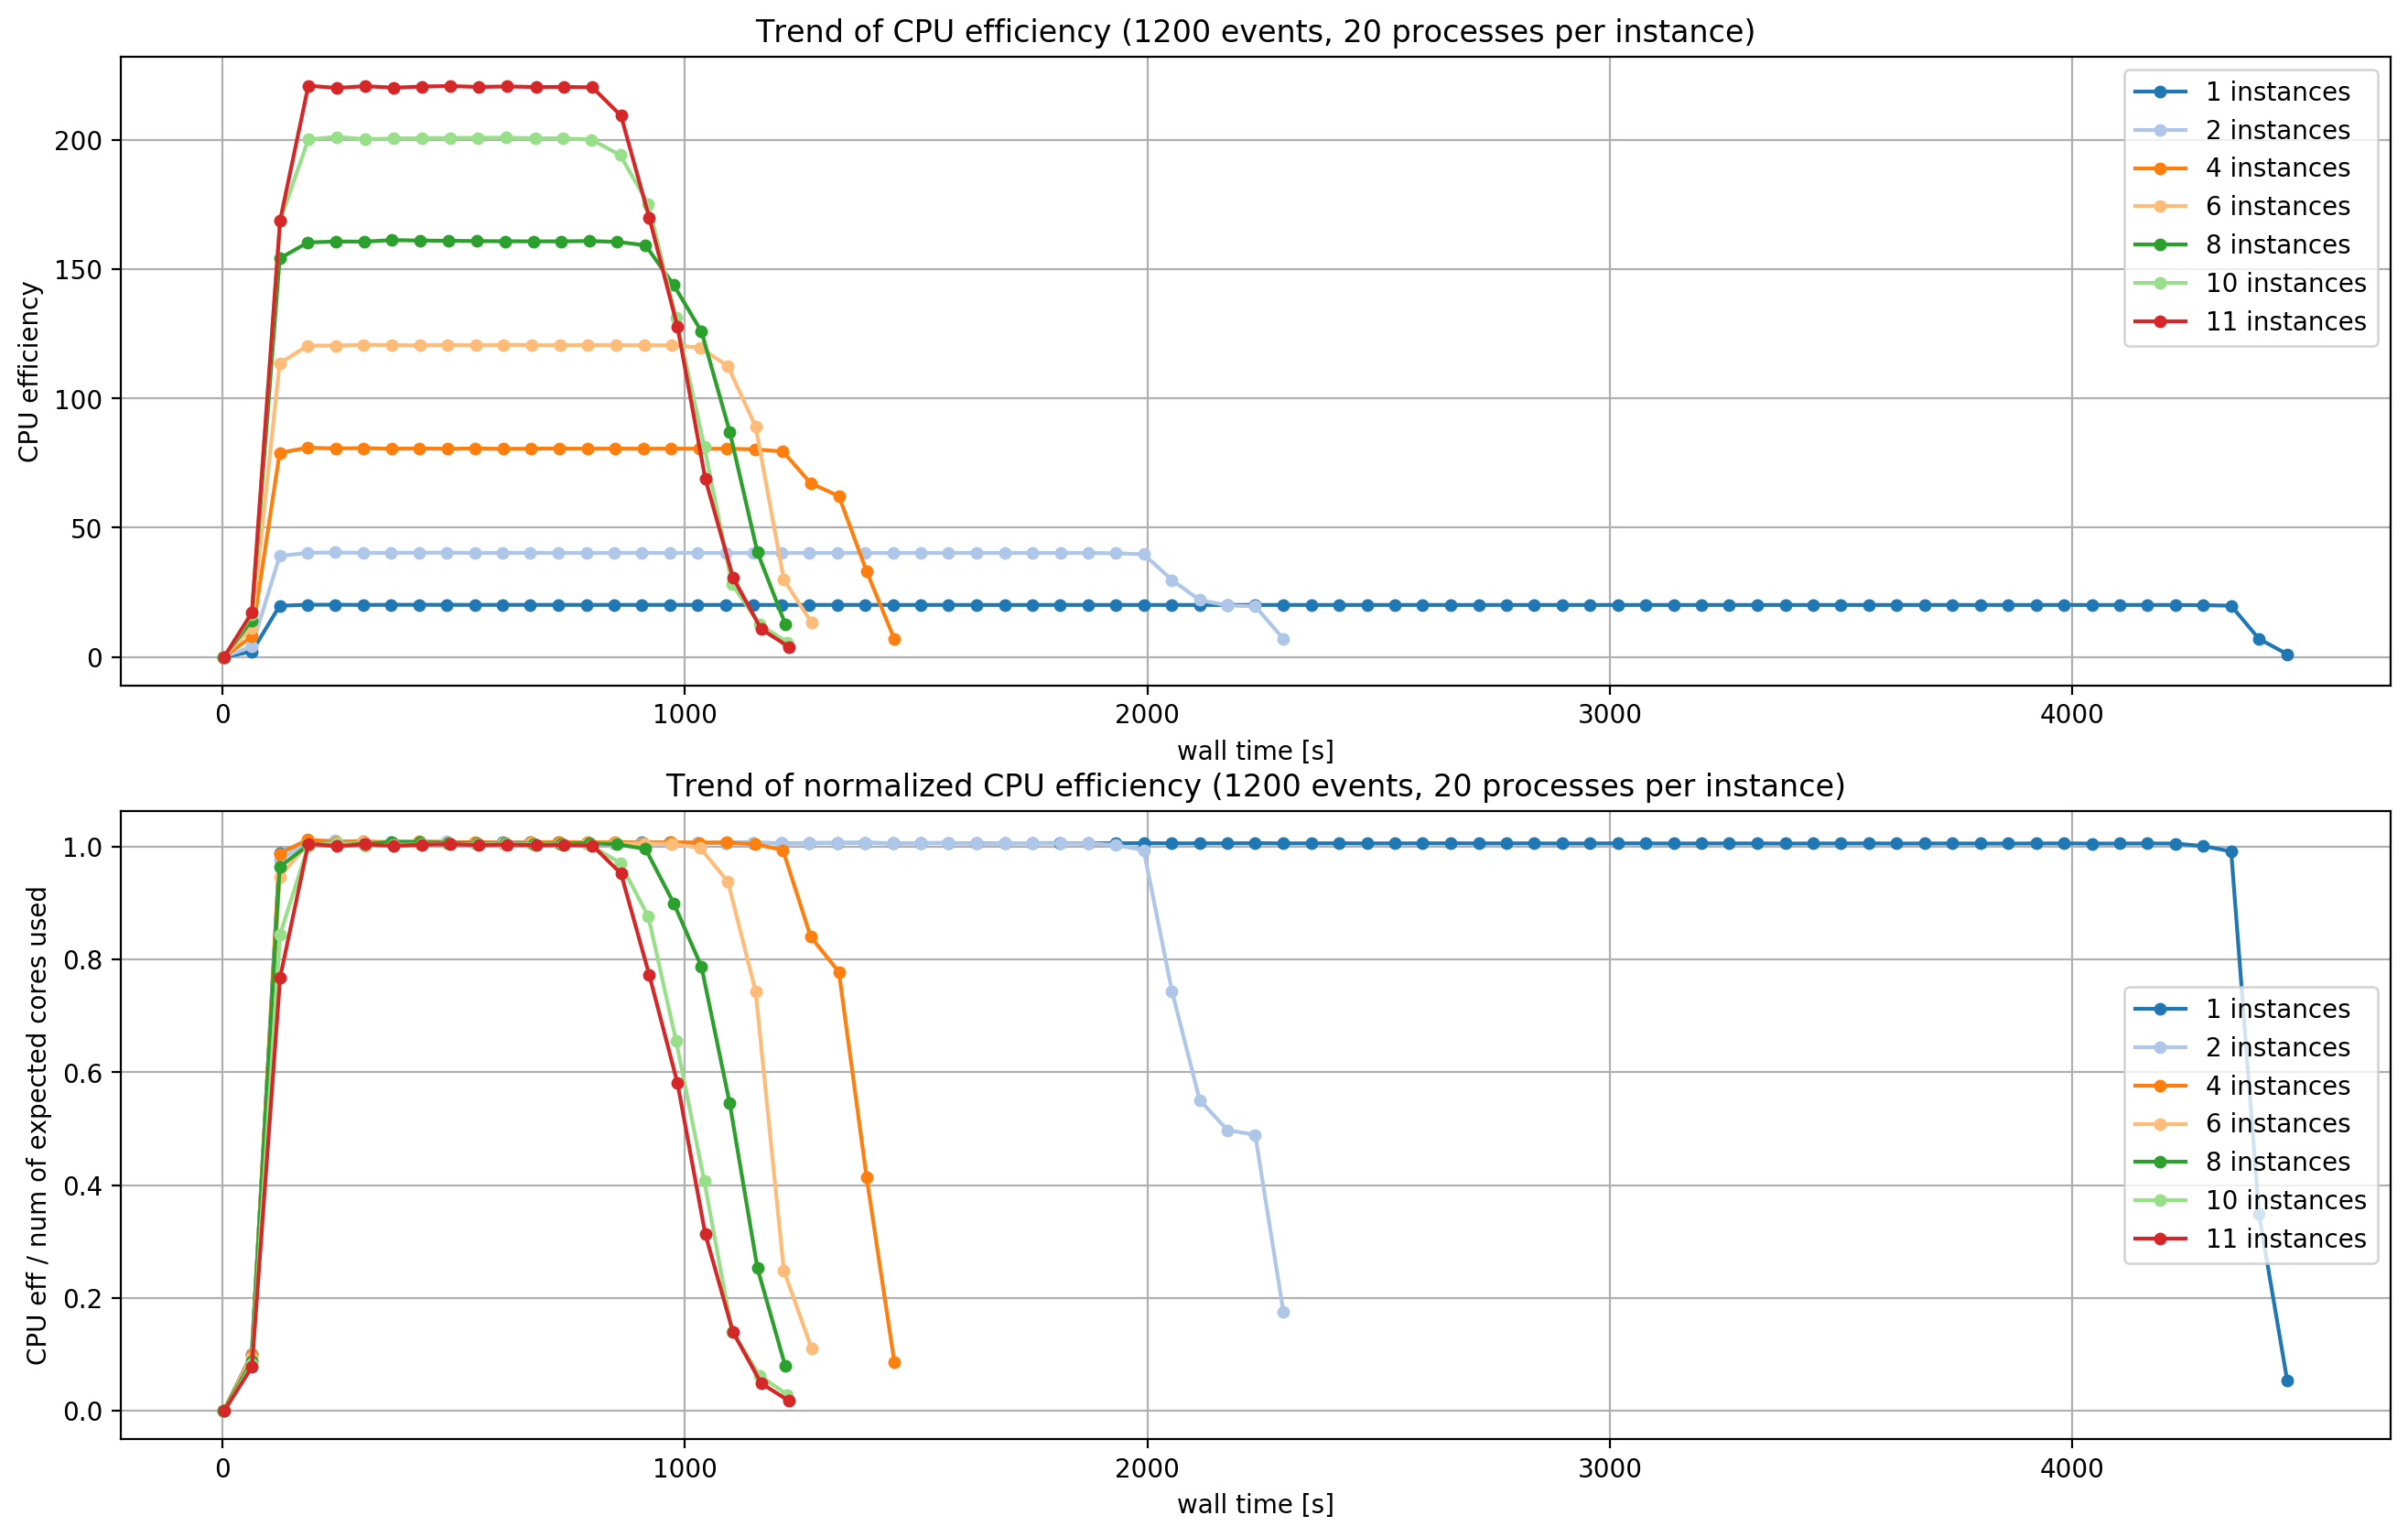

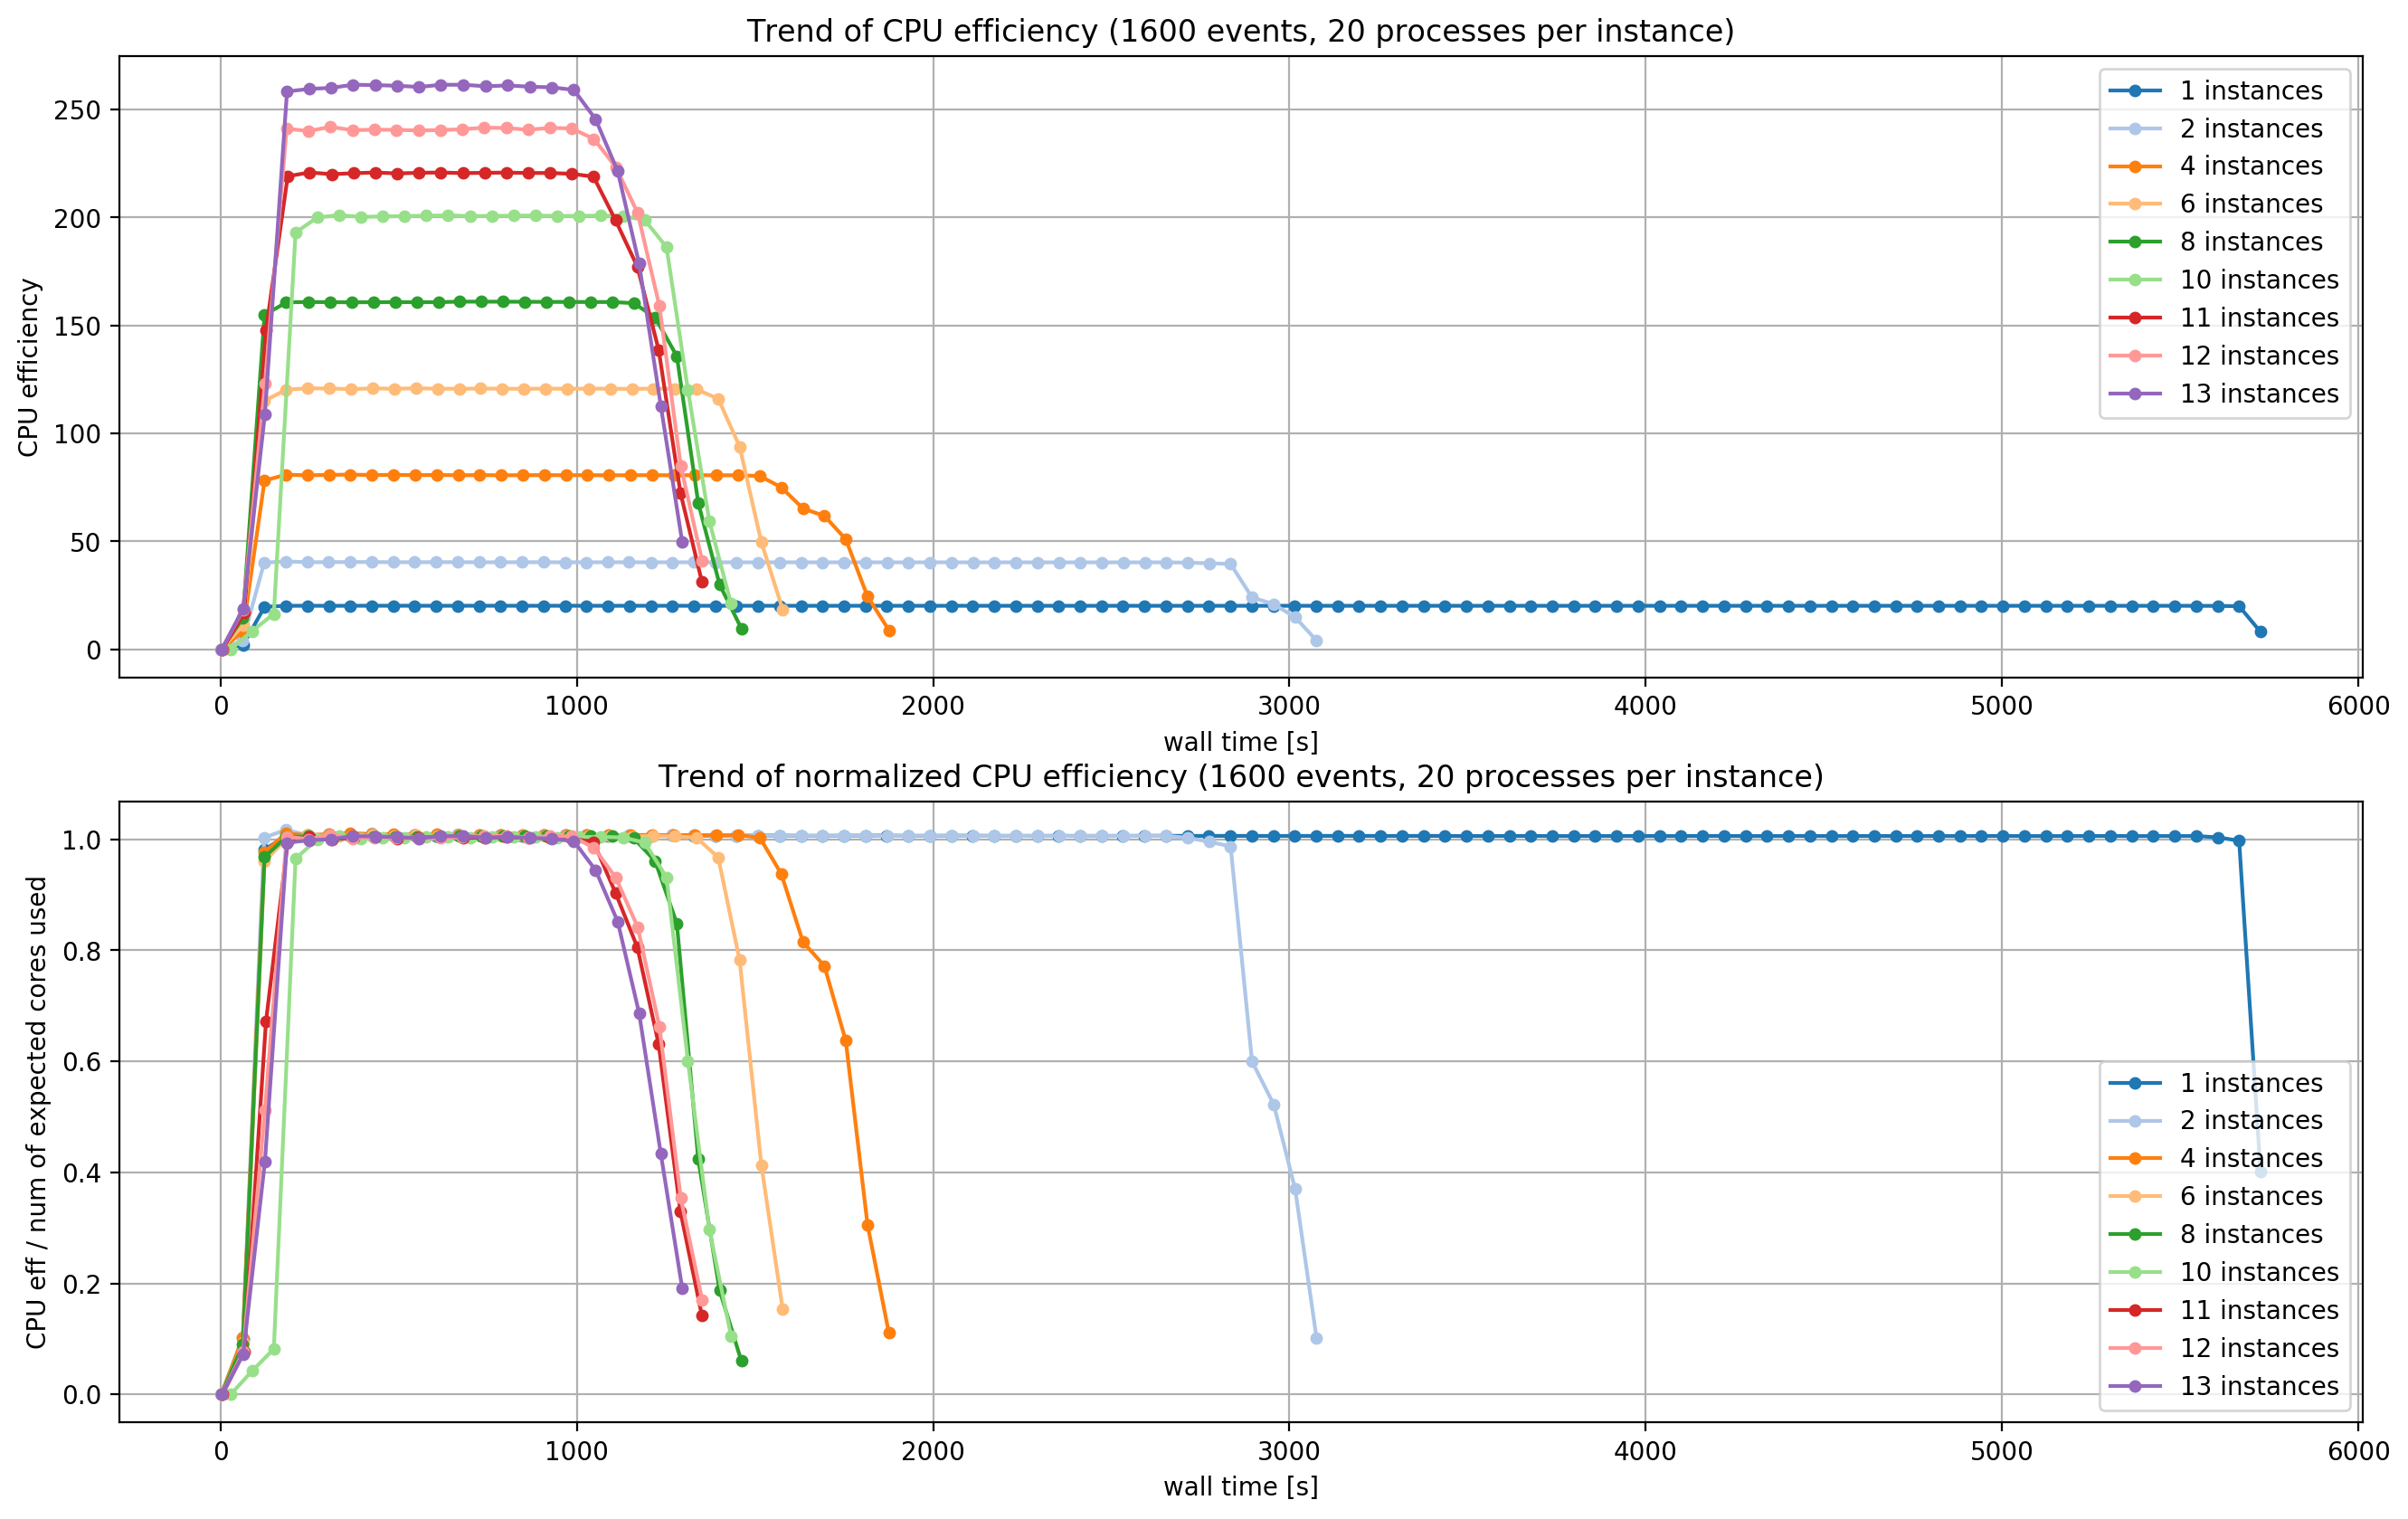

In [6]:
# Performance data over time for every job
psmon_slurm_raw = load_csv("psmon_slurm.csv", quiet=True)
psmon_not_ok = [ x["jobId"] for x in psmon_slurm_raw if x["nInst"] != x["nInstOk"] ]
psmon_raw = load_csv("psmon.csv", "rec['jobId'] not in psmon_not_ok", quiet=True)
#del psmon_slurm_raw, psmon_not_ok

psmon_fig = []
psmon_ax = []
for n_evt in sorted({x["nEvt"] for x in psmon_raw}):
    # For each event set, do a different plot
    fig,ax = plt.subplots(2)
    psmon_fig.append(fig)
    psmon_ax.append(ax)
    cycol = cycler("color", get_cmap("tab20").colors).__iter__()
    for n_inst in sorted({x["nInst"] for x in psmon_raw if x["nEvt"] == n_evt}):
        # For each number of instances
        x,y1,ni,np = get_tuple(psmon_raw, ("elapsed", "cpuEff", "nInst", "nProc"), {"nInst": n_inst, "nEvt": n_evt})
        # Also create normalized version
        y2 = []
        for i in range(len(y1)):
            y2.append(y1[i] / (ni[i] * np[i]))
        prop = cycol.__next__()
        # Plot
        ax[0].plot(x, y1, "-", label=f"{n_inst} instances", **prop, marker="o", markersize=4)
        ax[1].plot(x, y2, "-", label=f"{n_inst} instances", **prop, marker="o", markersize=4)
    for a in ax:
        a.grid(True)
        a.legend()
        a.set_xlabel("wall time [s]")
    ax[0].set_title(f"Trend of CPU efficiency ({n_evt} events, {psmon_raw[0]['nProc']} processes per instance)")
    ax[0].set_ylabel("CPU efficiency");
    ax[1].set_title(f"Trend of normalized CPU efficiency ({n_evt} events, {psmon_raw[0]['nProc']} processes per instance)")
    ax[1].set_ylabel("CPU eff / num of expected cores used");
del a, ax, fig, x, y1, y2, prop, cycol, n_inst, n_evt, ni, np, i

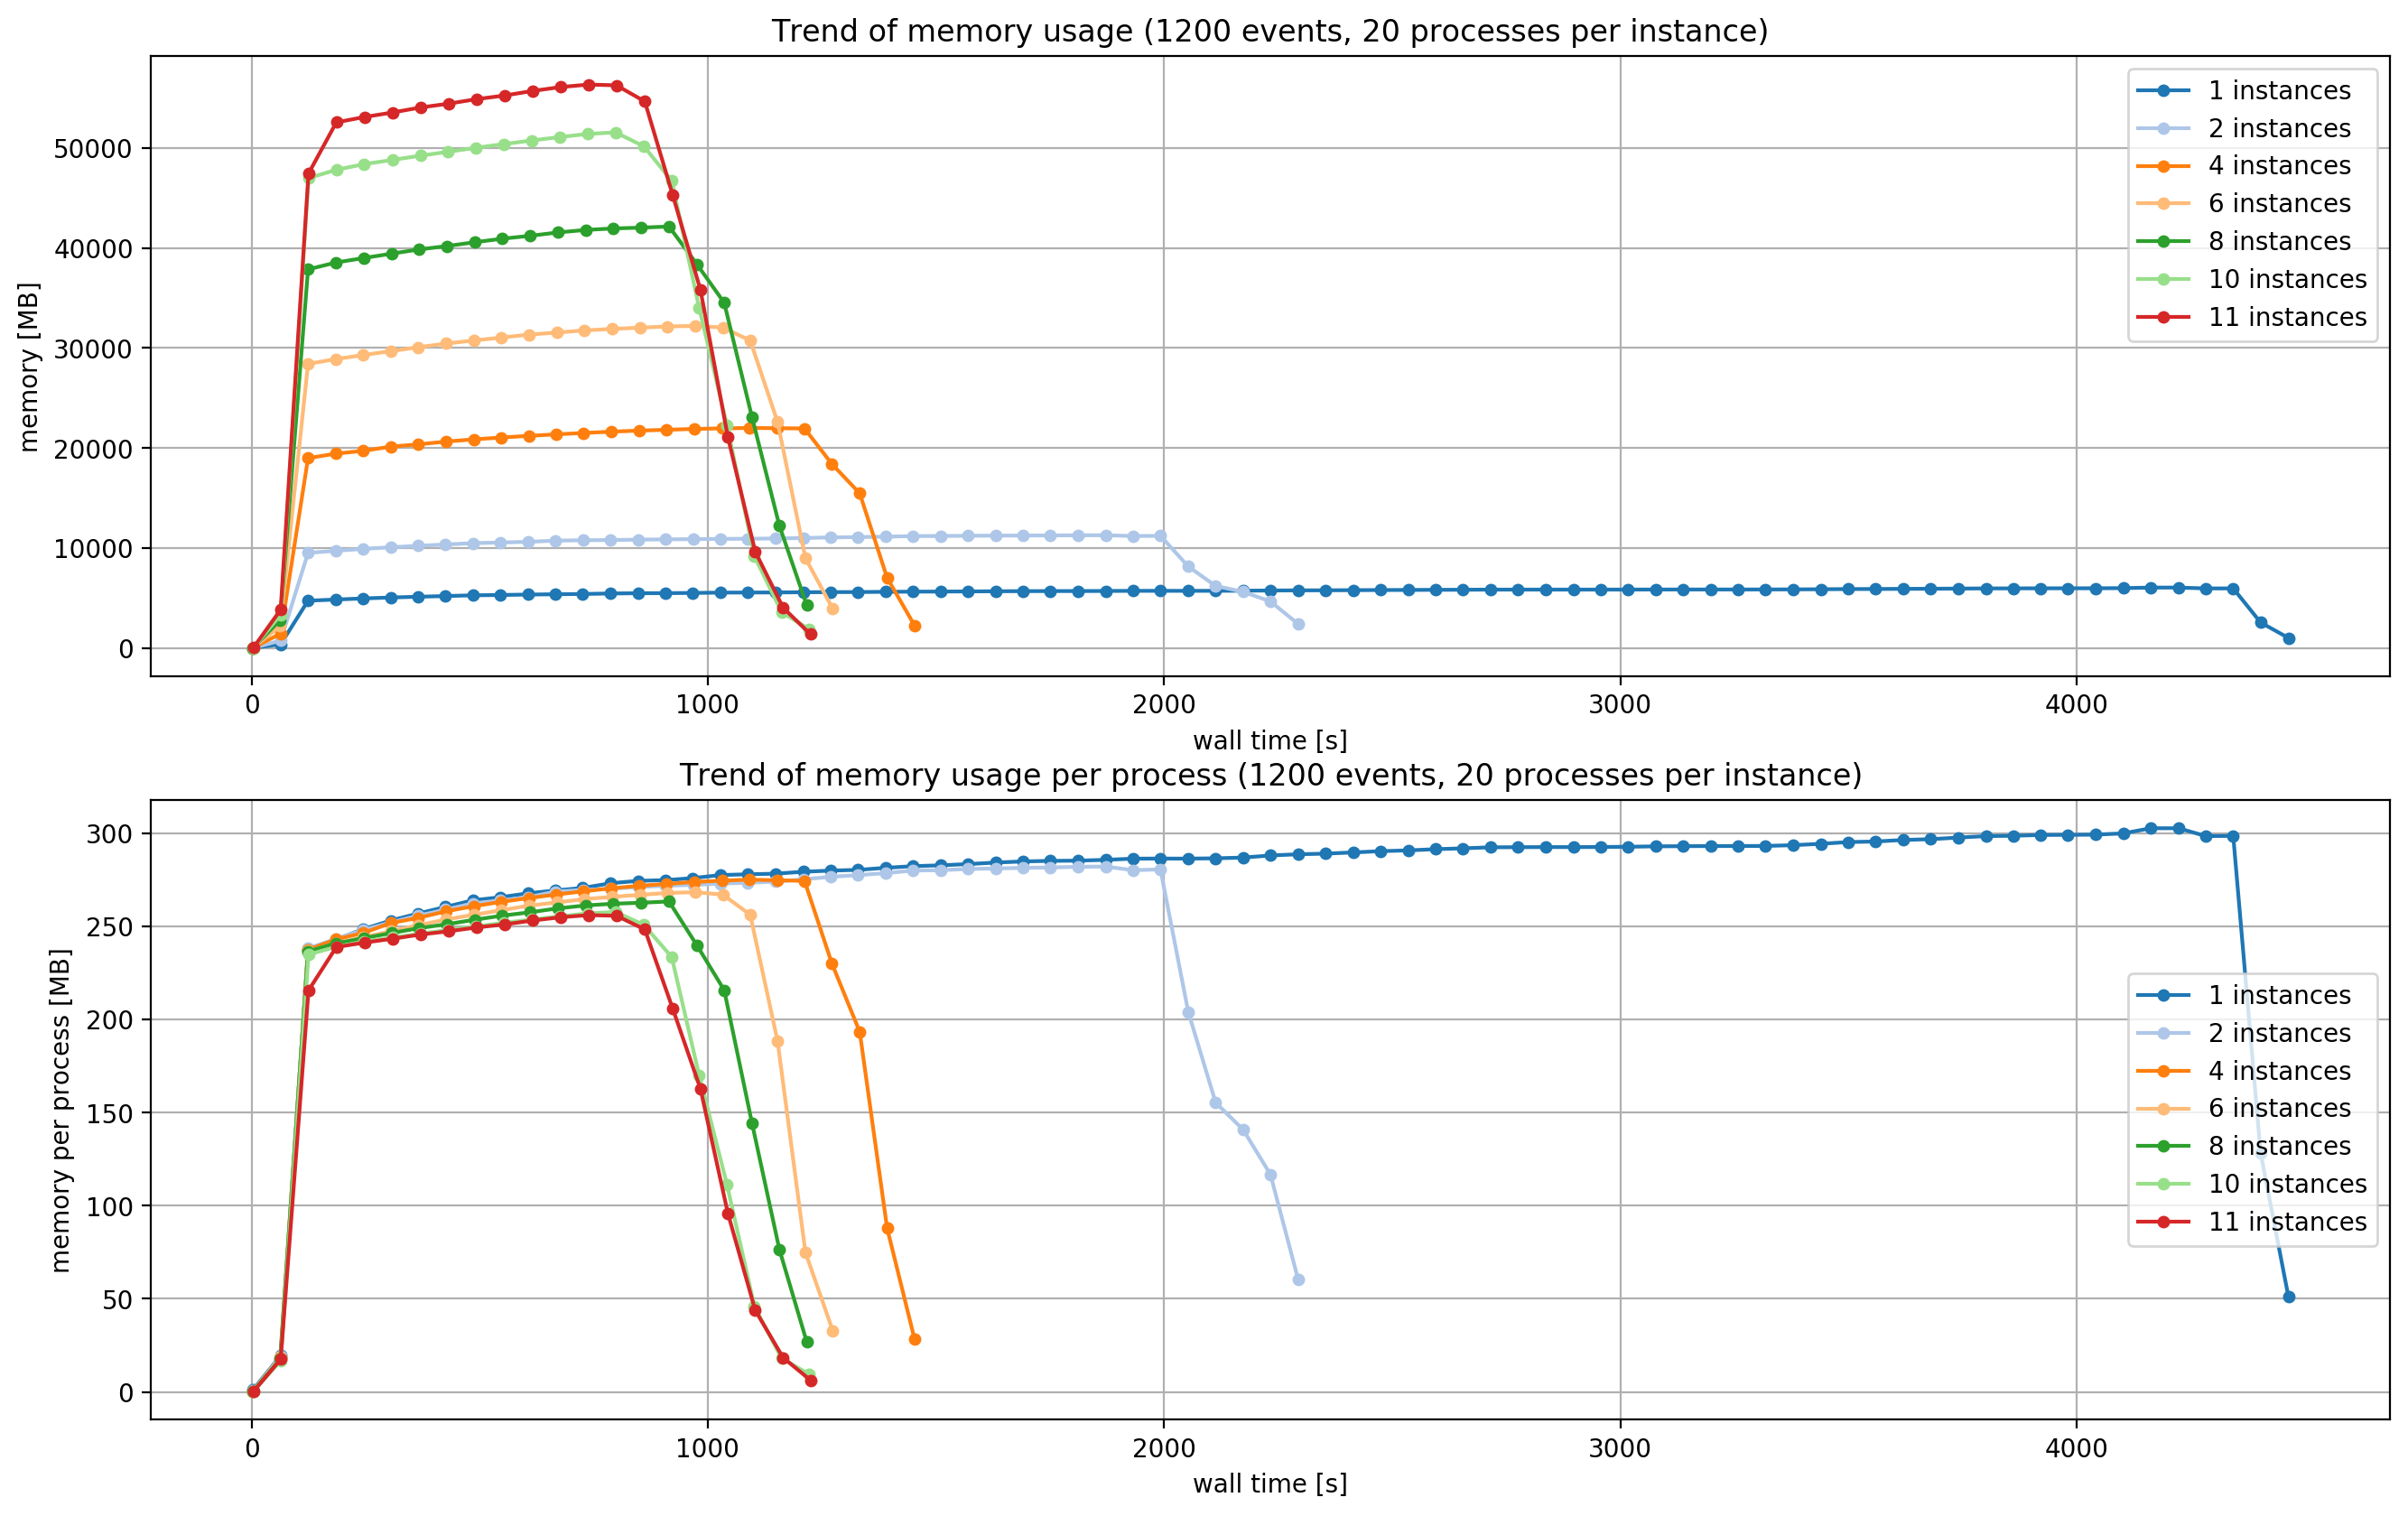

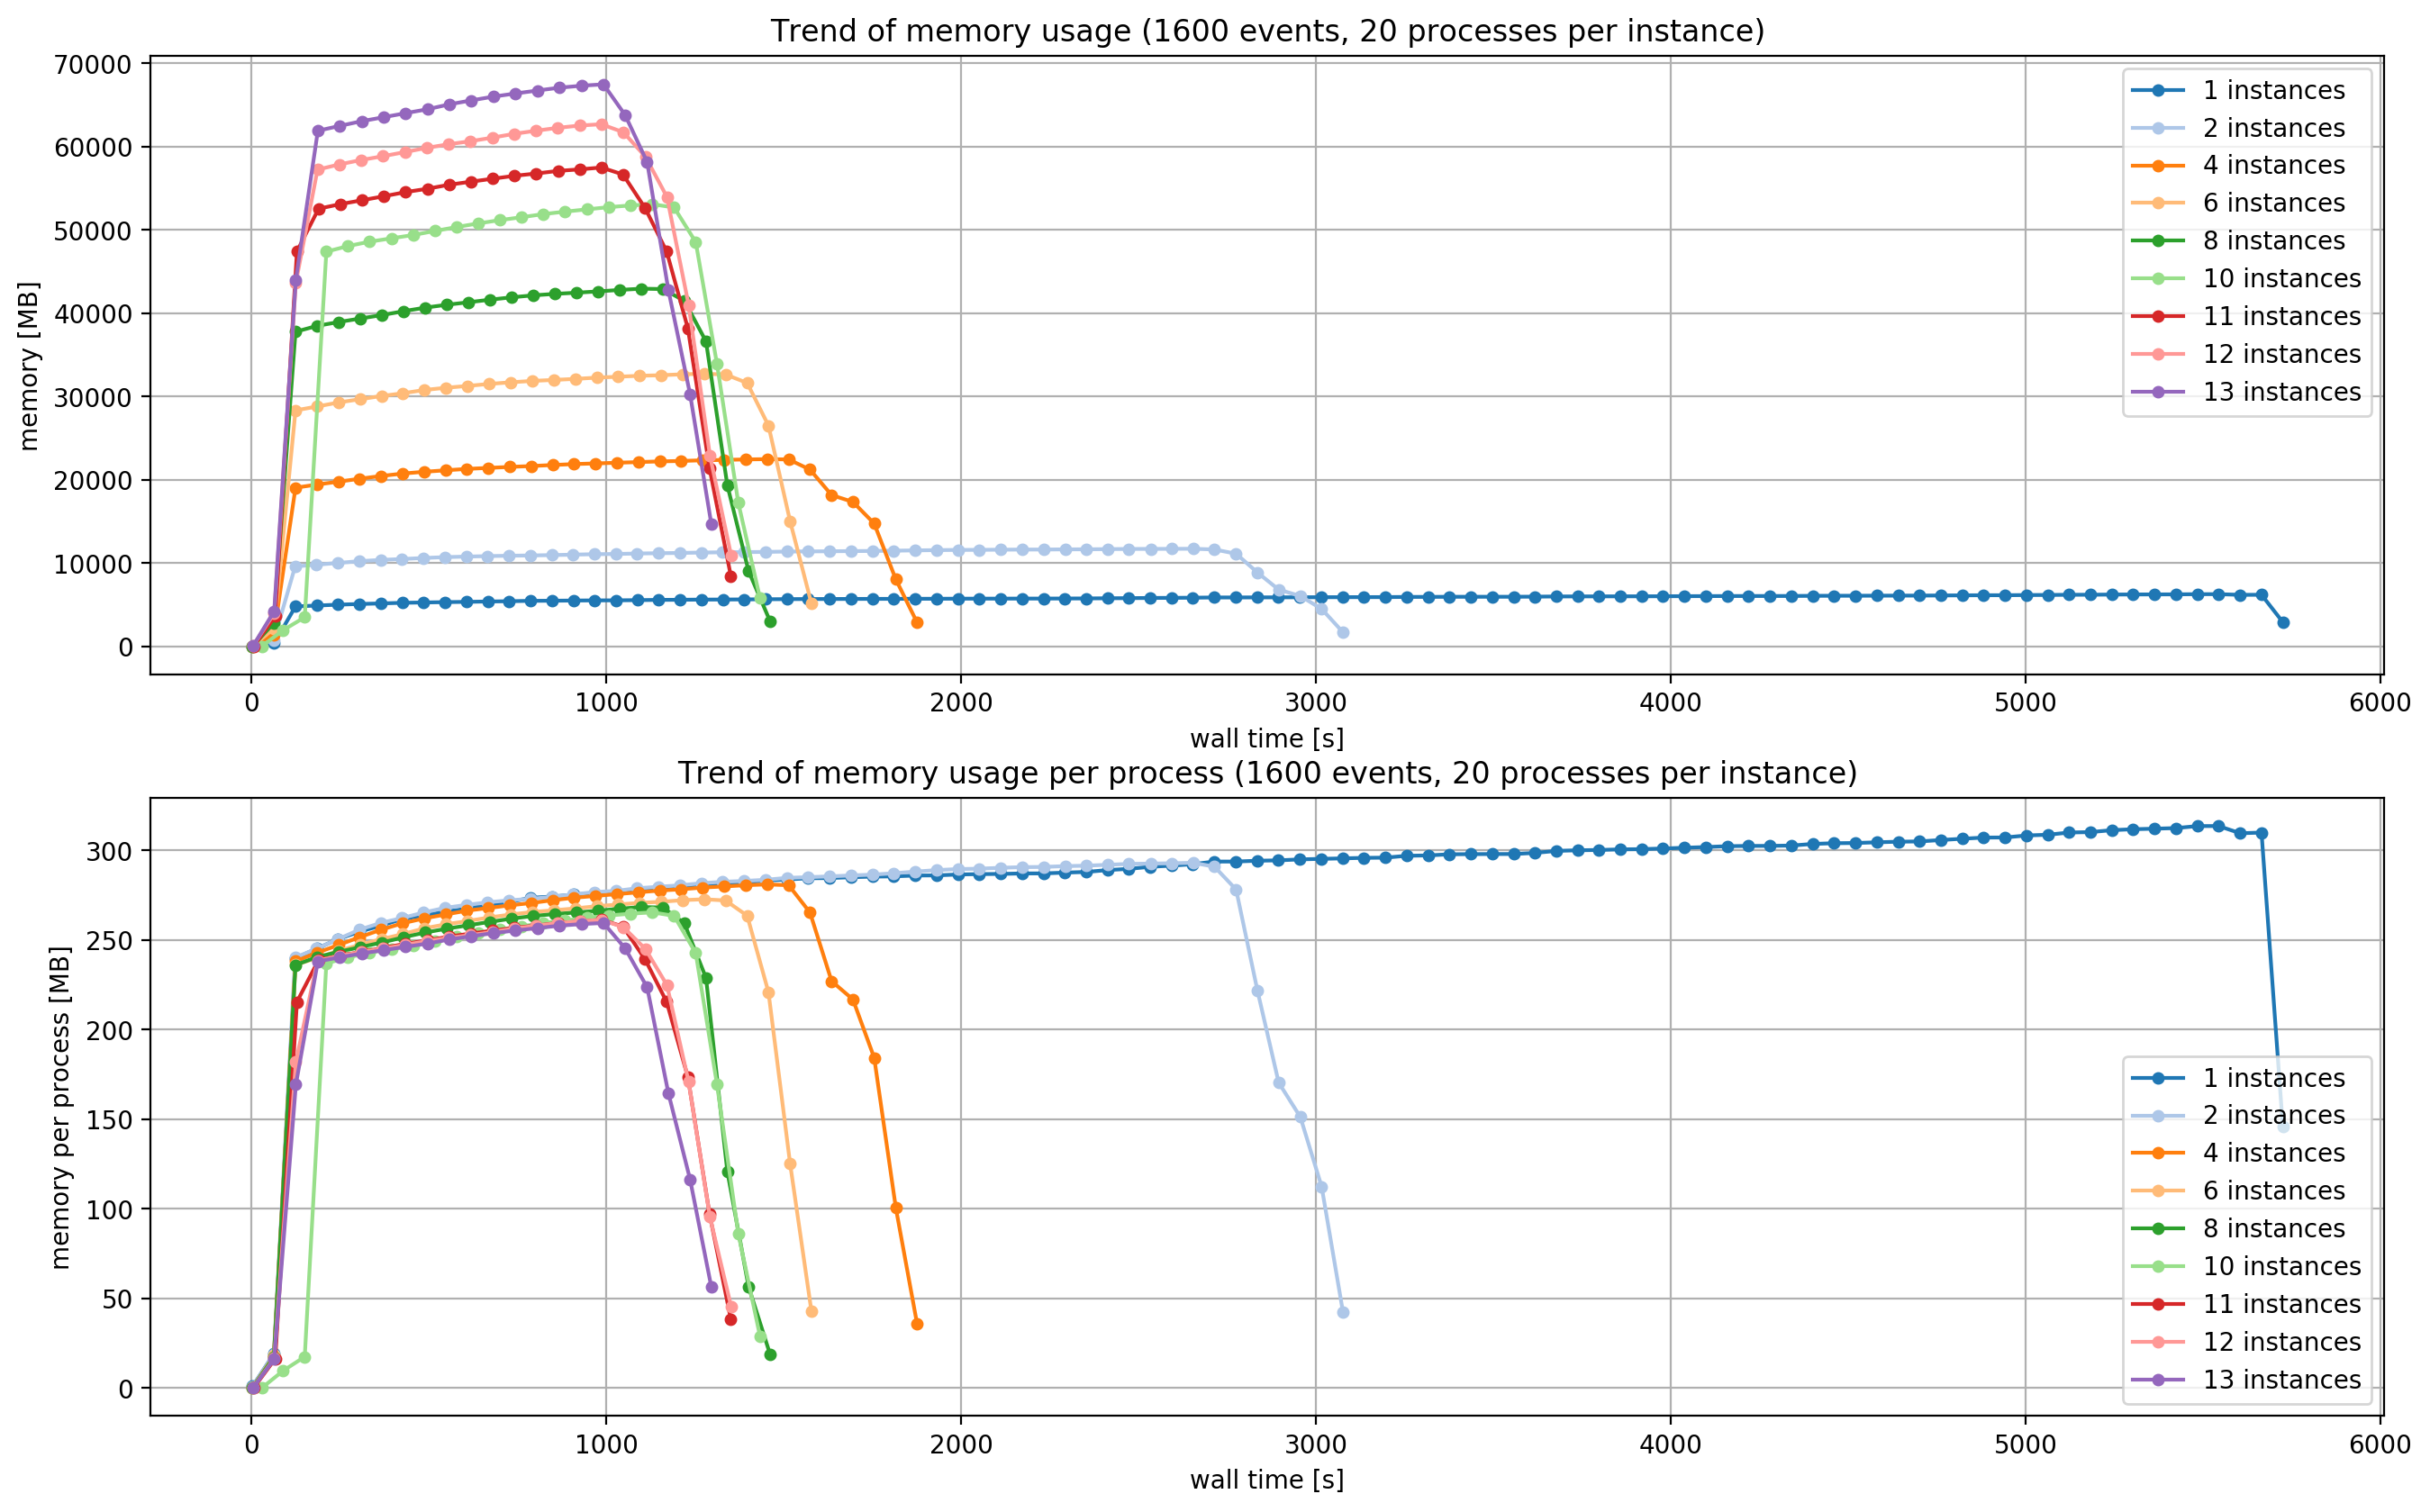

In [7]:
psmon_mem_fig = []
psmon_mem_ax = []
for n_evt in sorted({x["nEvt"] for x in psmon_raw}):
    # For each event set, do a different plot
    fig,ax = plt.subplots(2)
    psmon_mem_fig.append(fig)
    psmon_mem_ax.append(ax)
    cycol = cycler("color", get_cmap("tab20").colors).__iter__()
    for n_inst in sorted({x["nInst"] for x in psmon_raw if x["nEvt"] == n_evt}):
        # For each number of instances
        x,y1,ni,np = get_tuple(psmon_raw, ("elapsed", "rsz", "nInst", "nProc"), {"nInst": n_inst, "nEvt": n_evt})
        # Convert memory to MB
        y1 = [ i/1024 for i in y1 ]
        # Normalize
        y2 = []
        for i in range(len(y1)):
            y2.append(y1[i] / (ni[i] * np[i]))
        prop = cycol.__next__()
        # Plot
        ax[0].plot(x, y1, "-", label=f"{n_inst} instances", **prop, marker="o", markersize=4)
        ax[1].plot(x, y2, "-", label=f"{n_inst} instances", **prop, marker="o", markersize=4)
    for a in ax:
        a.grid(True)
        a.legend()
        a.set_xlabel("wall time [s]")
    ax[0].set_title(f"Trend of memory usage ({n_evt} events, {psmon_raw[0]['nProc']} processes per instance)")
    ax[1].set_title(f"Trend of memory usage per process ({n_evt} events, {psmon_raw[0]['nProc']} processes per instance)")
    ax[0].set_ylabel("memory [MB]");
    ax[1].set_ylabel("memory per process [MB]");
del a, ax, fig, x, y1, y2, prop, cycol, n_inst, n_evt, ni, np, i

Keys from multi_slurm_stats.csv: jobId, nEvt, nProc, nInst, nInstOk, nShMem, slurmUserCpu, slurmWallTime, slurmAveRss, slurmMaxRss
[196.8988764044944, 176.76404494382024, 223.32584269662922, 209.95505617977528, 233.3932584269663, 253.3707865168539, 229.46067415730337, 292.3820224719101, 316.4494382022472, 362.85393258426967, 217.19101123595505, 251.1685393258427, 320.8539325842696, 309.685393258427, 337.21348314606746, 345.86516853932585, 346.9662921348315, 352.94382022471905, 362.0674157303371, 365.685393258427, 386.13483146067415, 395.2584269662922, 419.9550561797753, 100.0, 291.91011235955057, 351.2134831460674, 365.2134831460674, 356.08988764044943, 360.65168539325845, 387.70786516853934, 374.49438202247194, 390.38202247191015, 399.03370786516854, 423.8876404494382, 423.7303370786517, 425.46067415730334, 265.16853932584274, 353.2584269662921, 376.3820224719101, 392.5842696629214, 382.35955056179773, 388.80898876404495, 391.1685393258427, 415.5505617977528, 416.80898876404495, 401.3

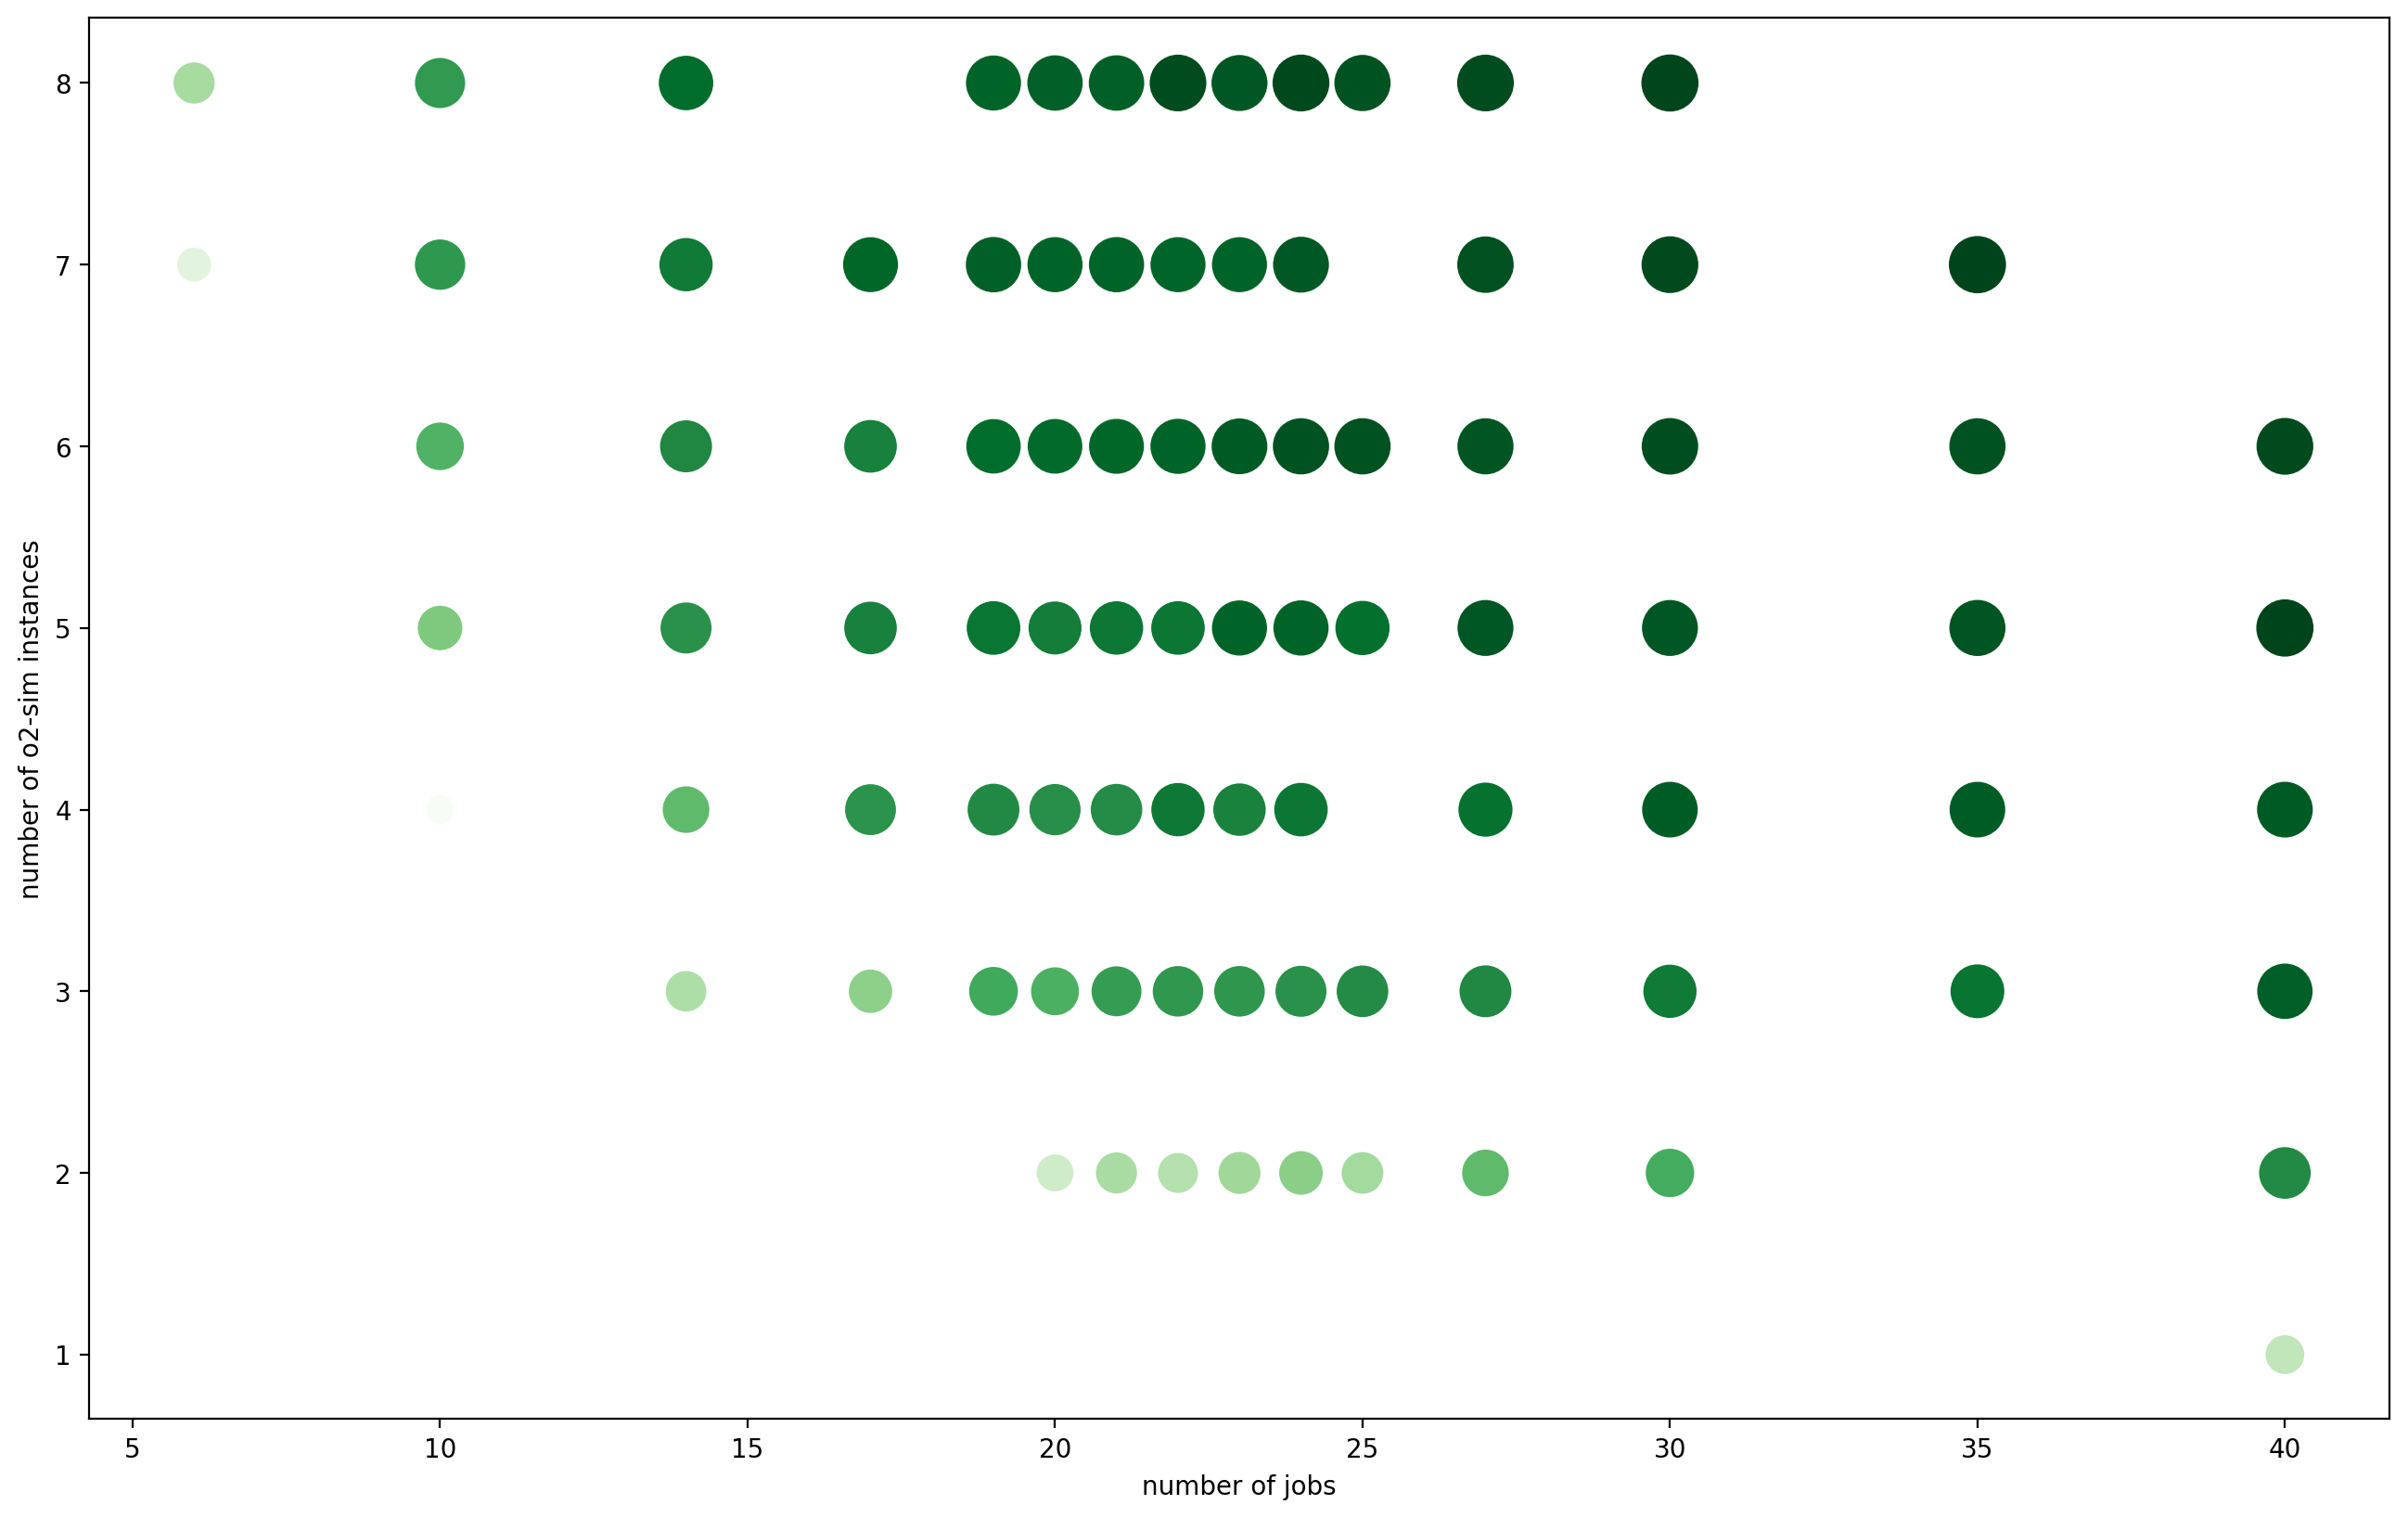

In [8]:
# Here we do some plots to find the optimal combinatio
# This is the point where we do the 2D plot
#




# Plot wall time vs. number of processes
multi_raw = load_csv("multi_slurm_stats.csv")

# Only healthy jobs are selected (make sure there are no WARNINGs on stdout!)
x,y,z = get_tuple(multi_raw, ("nProc", "nInst", "slurmWallTime"),
                  cond_eval="x['nShMem'] == x['nInst'] and x['nInst'] == x['nInstOk']")

multi_fig,multi_ax = plt.subplots()

# Normalize z: must be a value between 0, 1
zmax = float(max(z))
zmin = float(min(z))
zvar = zmax-zmin
zn = [1.-((float(i)-zmin)/zvar) for i in z]
contcol = get_cmap("Greens")  # rainbow
zc = list(map(contcol, zn))
smin = 100.
smax = 450.
svar = smax - smin
zs = [ smin + svar * (1.-(float(i)-zmin)/zvar) for i in z]

print(zs)

multi_ax.scatter(x, y, color=zc, marker="o", s=zs)
multi_ax.set_xlabel("number of jobs")
multi_ax.set_ylabel("number of o2-sim instances")

del zmax, zmin, zvar, x, y, z, zc, zs

In [74]:
# Plot wall time vs. number of processes
multi_raw = load_csv("multi_slurm_stats.csv")

# Only healthy jobs are selected (make sure there are no WARNINGs on stdout!)
x,y,z,ev = get_tuple(multi_raw, ("nProc", "nInst", "slurmWallTime", "nEvt"),
                     cond_eval="x['nShMem'] == x['nInst'] and x['nInst'] == x['nInstOk']")

Keys from multi_slurm_stats.csv: jobId, nEvt, nProc, nInst, nInstOk, nShMem, slurmUserCpu, slurmWallTime, slurmAveRss, slurmMaxRss


In [18]:
# Create a meshgrid that we will plot
X, Y = np.meshgrid(x, y)
Z = np.zeros([len(X),len(X[0])])

In [20]:
for ix in range(len(X)):
    for iy in range(len(X[ix])):
        nProc = X[ix,iy]
        nInst = Y[ix,iy]
        indices = (i for i,e in enumerate(x) if e == nProc)
        index = None
        for i in indices:
            if y[i] == nInst:
                index = i
                break
        if index is not None:
            Z[ix,iy] = z[index]
        #else:
        #    # Null values
        #    Z[ix,iy] = 0
        #print(f"nProc={nProc}, nInst={nInst}, index={index}")

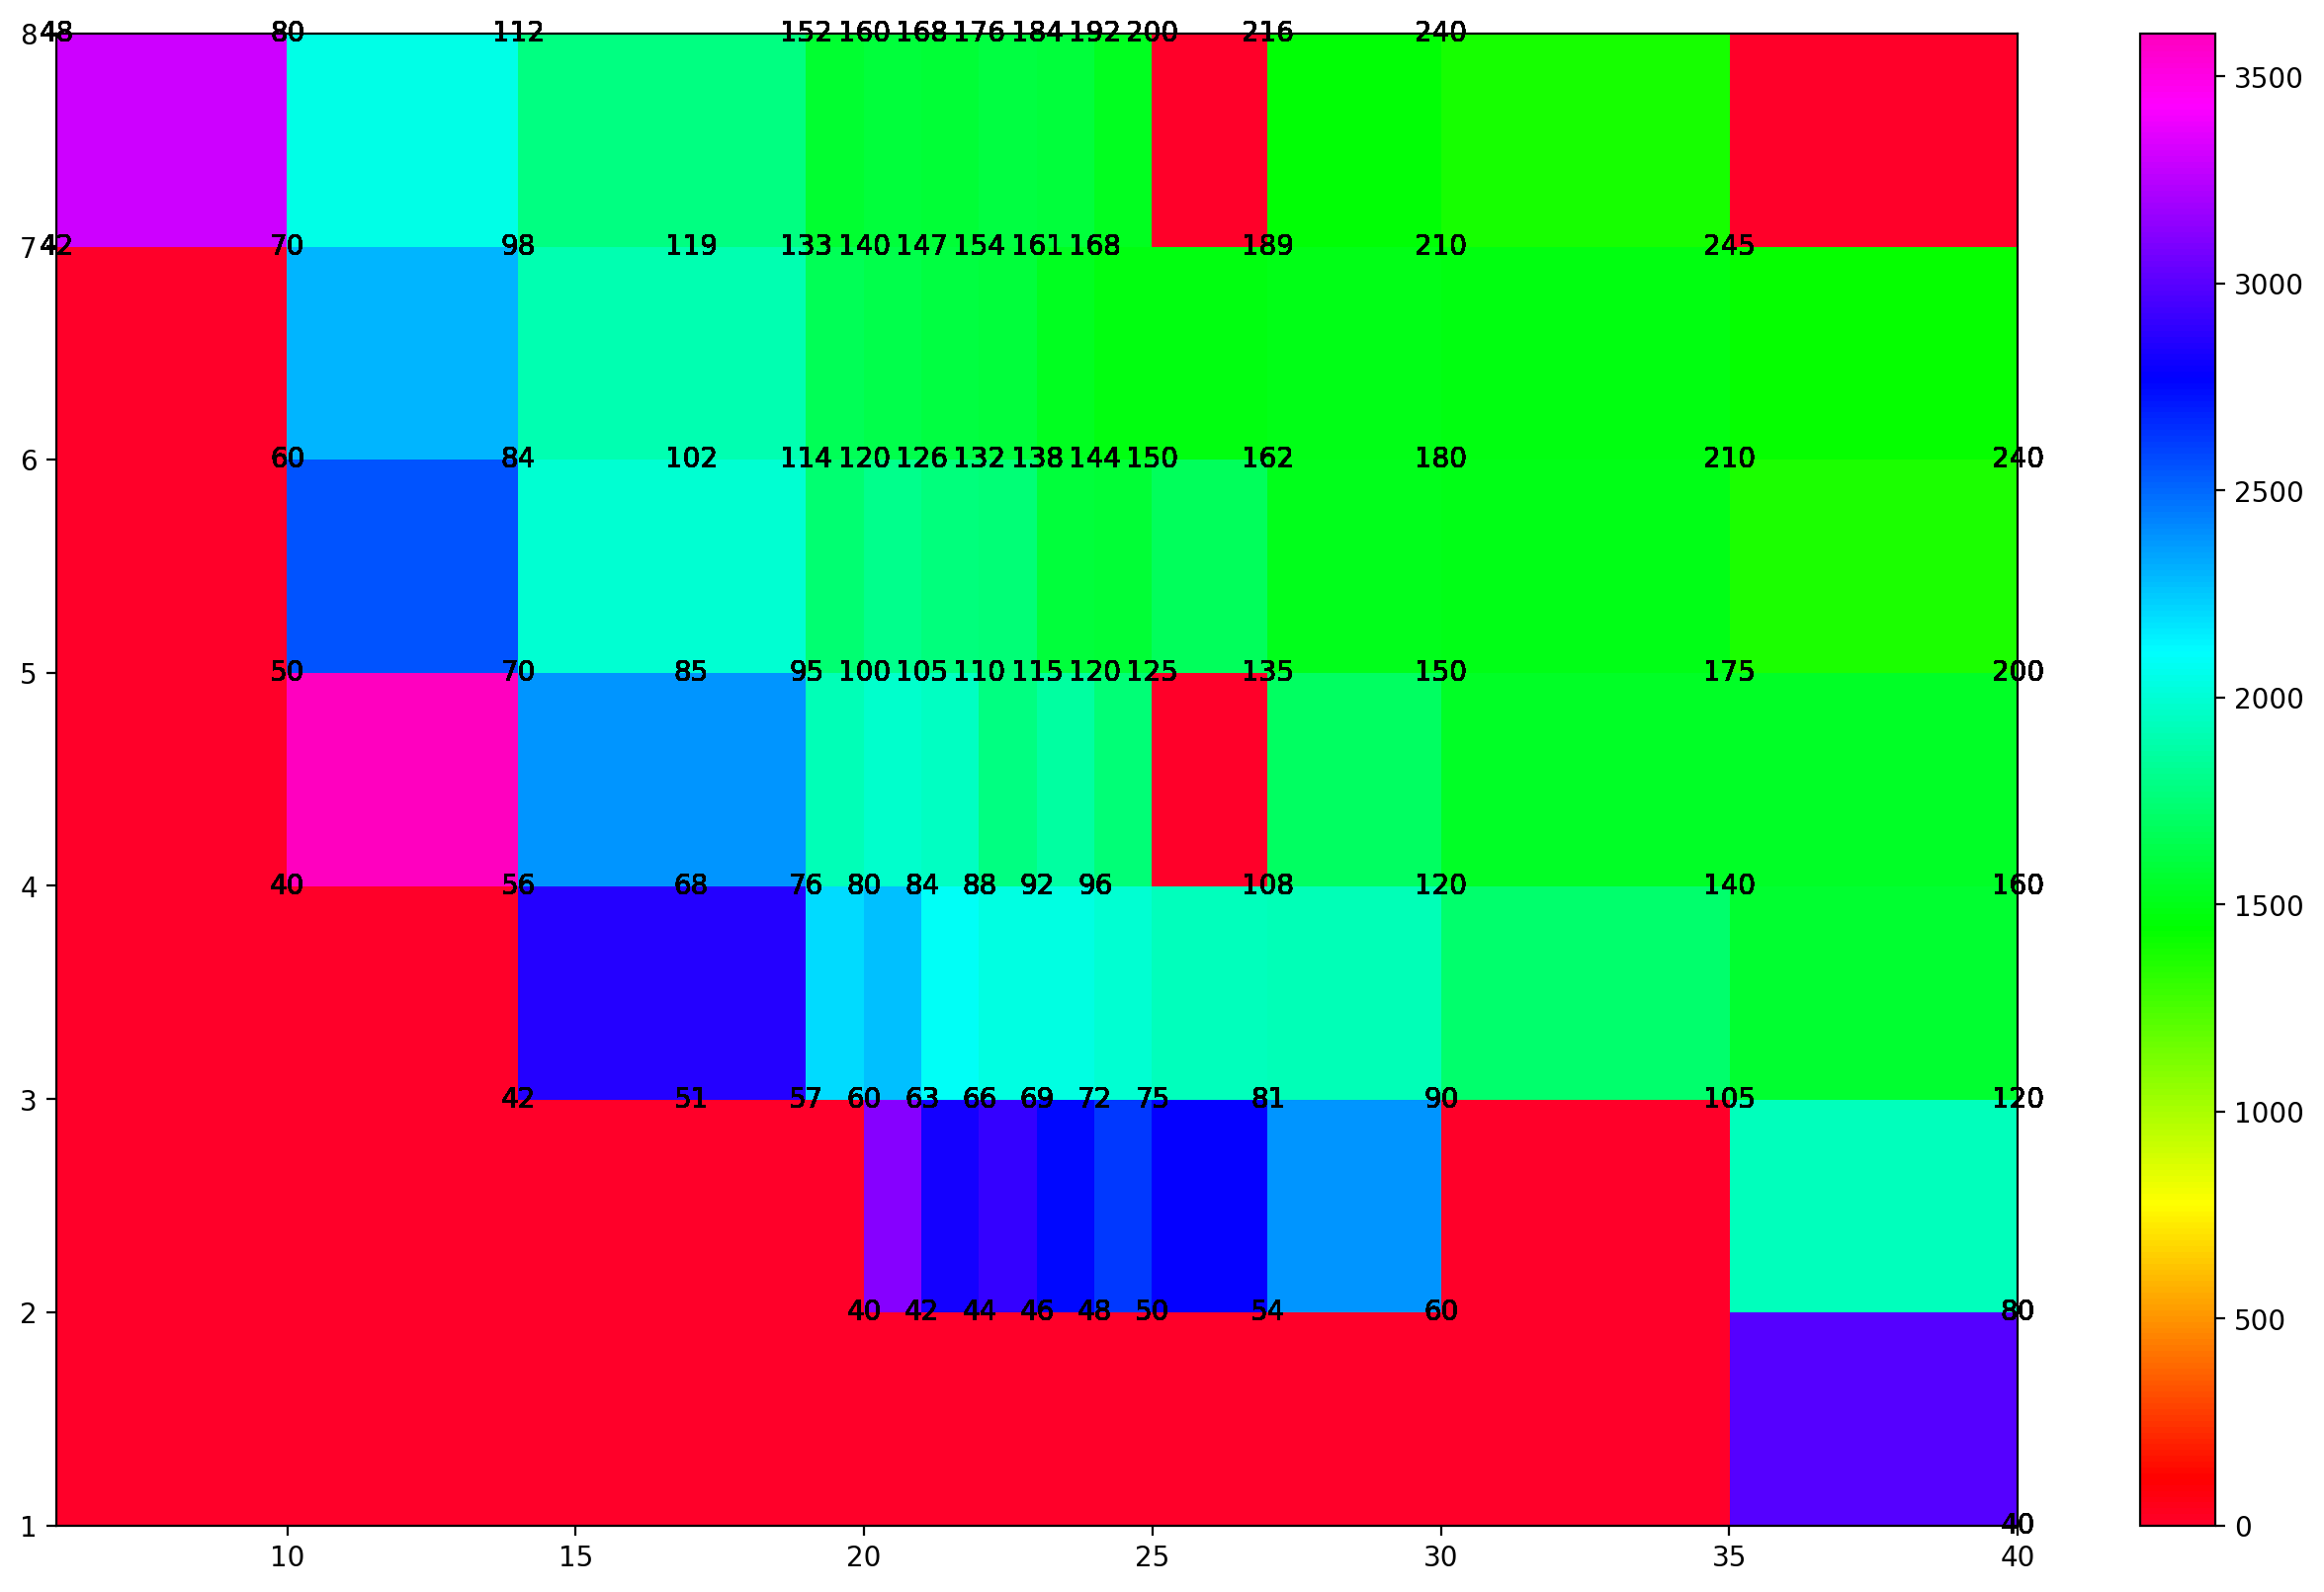

In [21]:
fig, ax = plt.subplots()
CS = ax.pcolormesh(X, Y, Z, cmap=plt.cm.gist_rainbow)
fig.colorbar(CS)
#help(fig.colorbar)
for ix in range(len(X)):
    for iy in range(len(X[ix])):
        if Z[ix,iy] != 0:
            ax.text(X[ix,iy], Y[ix,iy], f"{X[ix,iy]*Y[ix,iy]}", ha="center", va="center")
#ax.text(15,4, "puppo", ha="center", va="center")

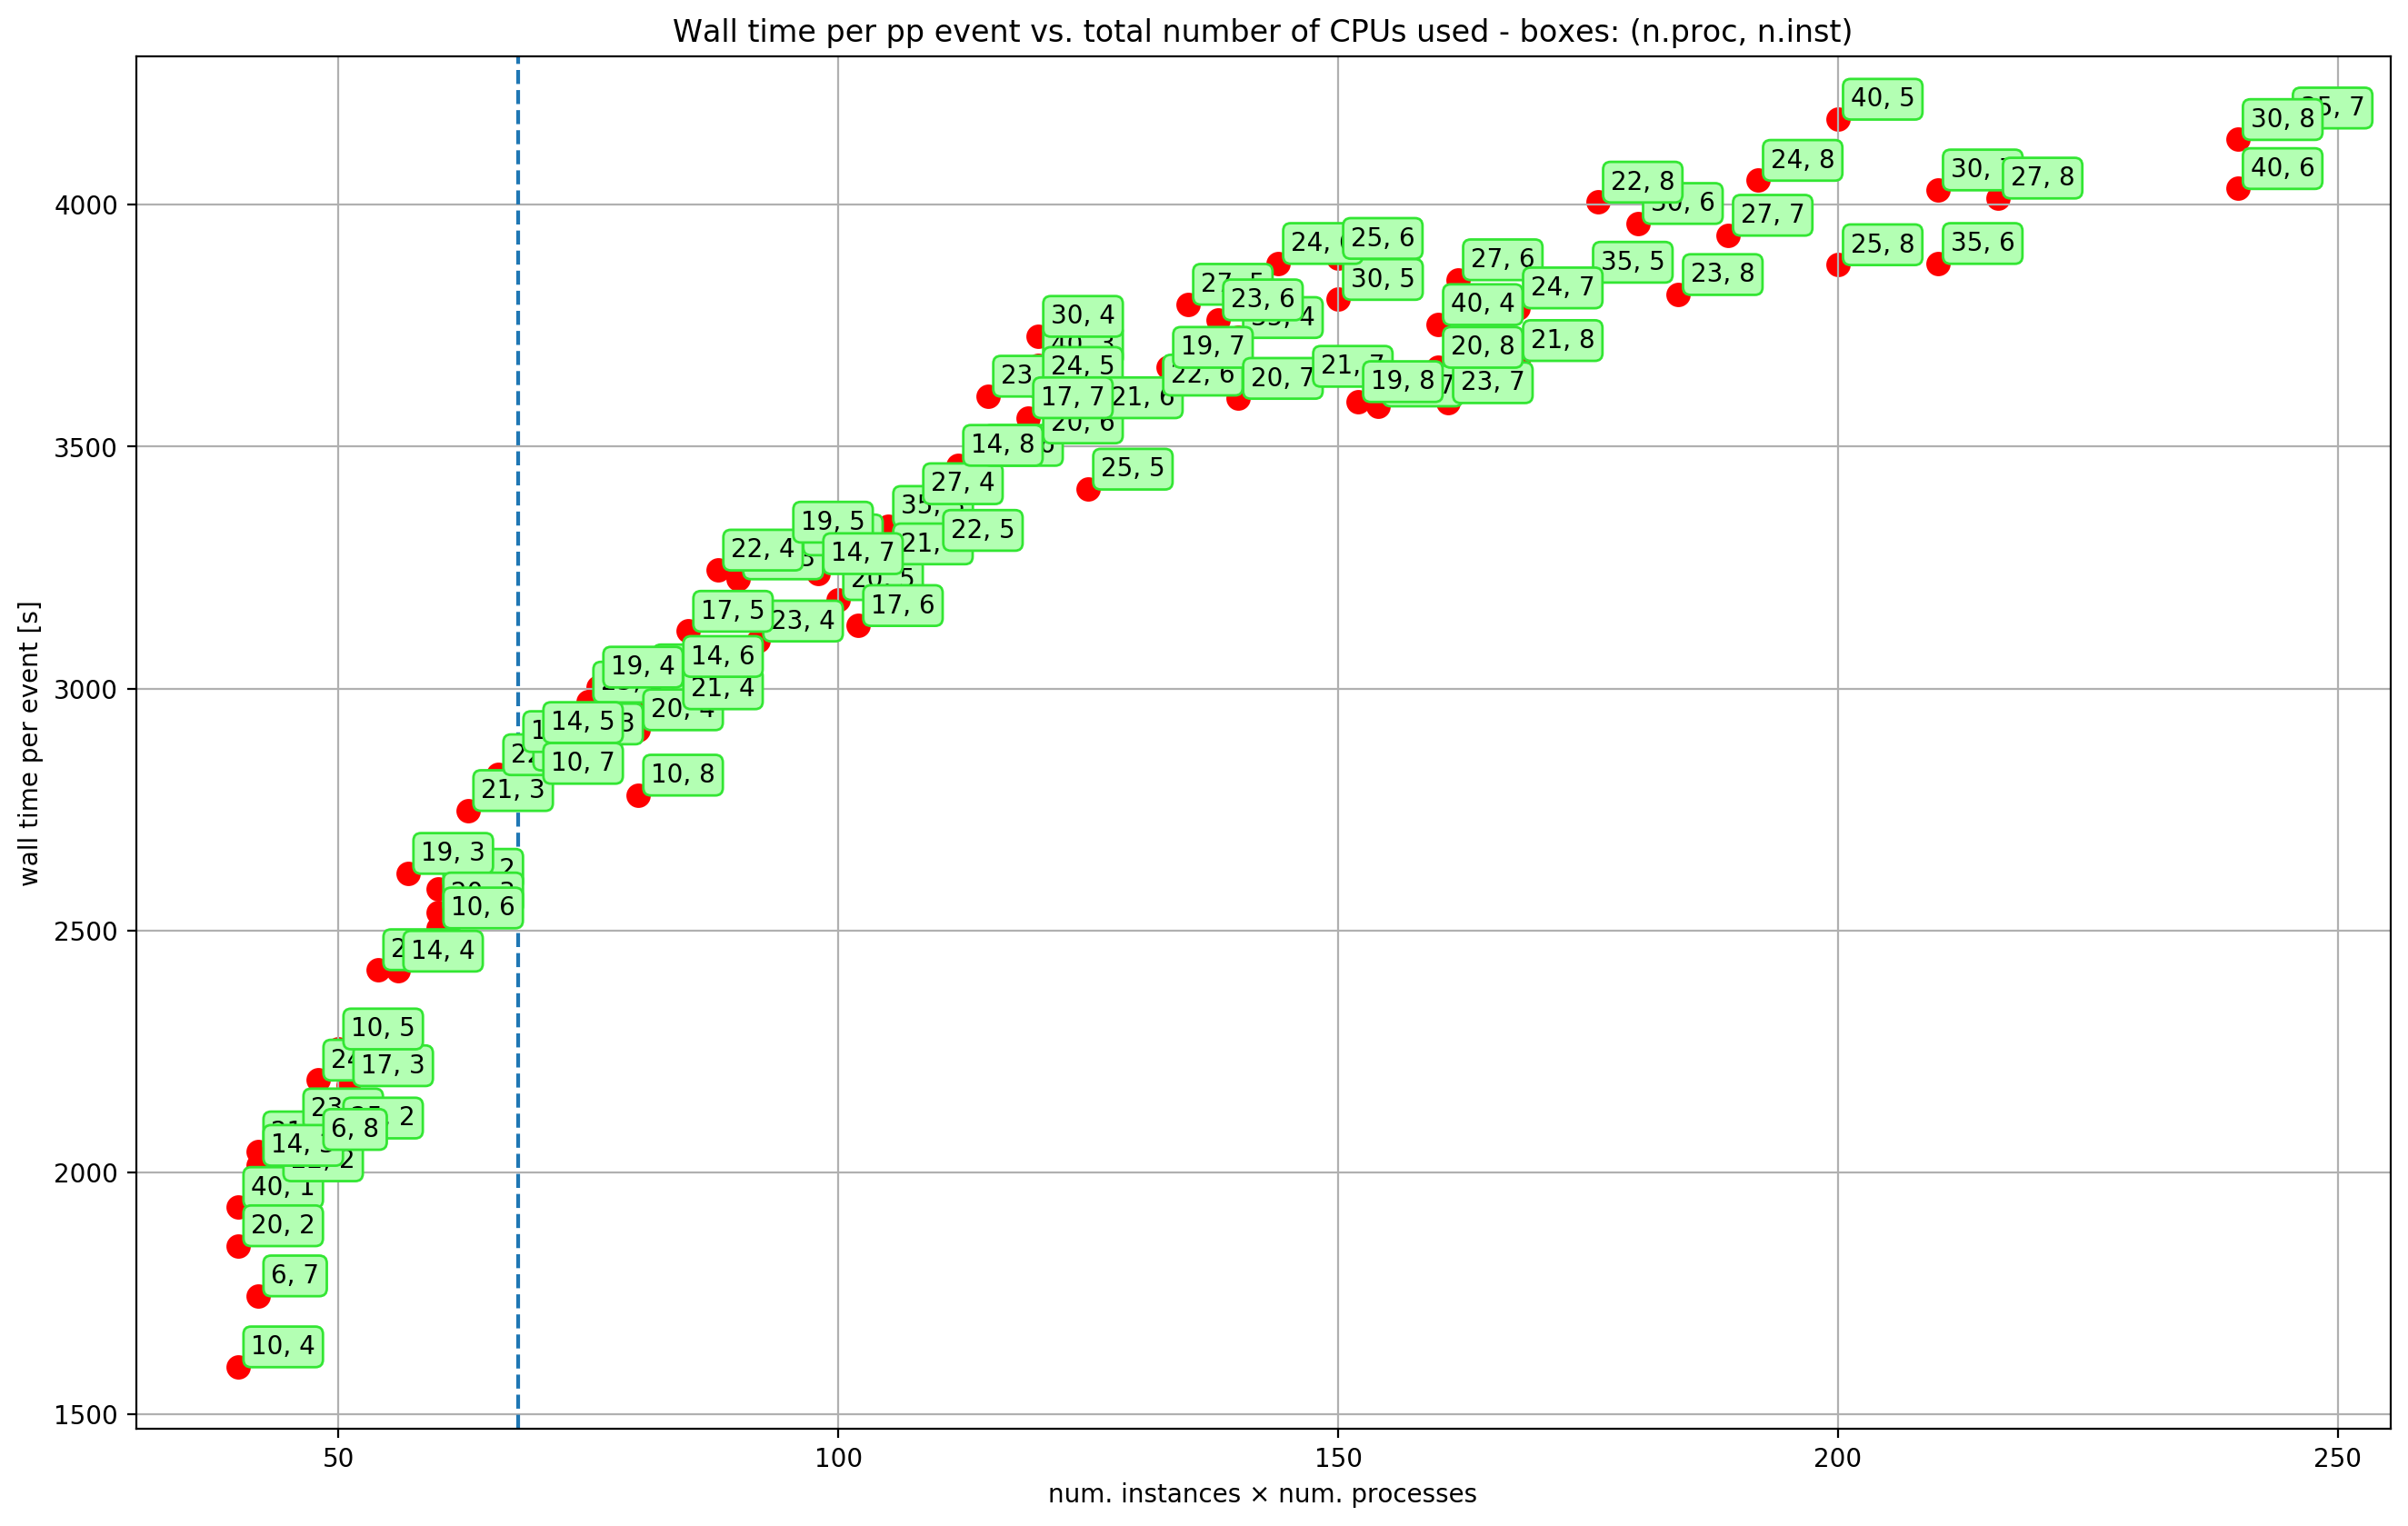

In [97]:
xx = np.array(x)
yy = np.array(y)
ww = np.array(z) / ev[0]  # wall time per event
cc = xx * yy

# Filter
#cond = aa > 68 # 1800
cond = ww < 3.0  # less than one second per event
cf = cc[cond]  # filtered tot. num. CPUs used
wf = ww[cond]  # filtered wall time per event
xf = xx[cond]  # filtered num. processes
yf = yy[cond]  # filtered num. instances

# From wall time to number of evts in 2h
nn = 3600 / ww
wf = nn[cond]  # TODO nf not wf

# Plot
fig,ax = plt.subplots()
ax.scatter(cf, wf, marker="o", s=75, c=[(1., 0., 0.)])
for a,b,c,d in zip(xf,yf,cf,wf):
    ax.annotate(s=f"{a}, {b}",
                textcoords="offset points",
                xy=(c, d),
                xytext=(5, 5),
                bbox={"boxstyle": "round",
                      "fc": (0.7, 1.0, 0.7),
                      "ec": (0.2, 0.9, 0.2)})
ax.axvline(68, linestyle="dashed", label="poppa")
ax.grid(True)
ax.set_title("Wall time per pp event vs. total number of CPUs used - boxes: (n.proc, n.inst)")
ax.set_xlabel("num. instances × num. processes")
ax.set_ylabel("wall time per event [s]");

In [89]:
help(ax.axvline)

Help on method axvline in module matplotlib.axes._axes:

axvline(x=0, ymin=0, ymax=1, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Add a vertical line across the axes.
    
    Parameters
    ----------
    x : scalar, optional, default: 0
        x position in data coordinates of the vertical line.
    
    ymin : scalar, optional, default: 0
        Should be between 0 and 1, 0 being the bottom of the plot, 1 the
        top of the plot.
    
    ymax : scalar, optional, default: 1
        Should be between 0 and 1, 0 being the bottom of the plot, 1 the
        top of the plot.
    
    Returns
    -------
    line : :class:`~matplotlib.lines.Line2D`
    
    Other Parameters
    ----------------
    **kwargs
        Valid kwargs are :class:`~matplotlib.lines.Line2D` properties,
        with the exception of 'transform':
    
      agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
      alpha: f